Input

ACCEL data
Process: dimension reduction

Simple PCA (principal component analysis)
Principal factors with oblimin rotation: see https://www.sciencedirect.com/science/article/pii/S0022395616301297?via%3Dihub

# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
import re
import textwrap
import seaborn as sns

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


## File I/O

In [2]:
# Input
dir_source = os.path.join(dir_home, "data", "accel_ukbb_202305", "split")

# Output
dir_out = os.path.join(dir_home, "analysis", "specific",
                       "analysis_20230628_01_ACCEL_dimension_reduction")
dir_out_plot = os.path.join(dir_out, "plot")
dir_out_hist = os.path.join(dir_out, "plot", "histogram")
dir_out_pairplot = os.path.join(dir_out, "plot", "pair_plot")

# Create output folder only if it doesn't exist yet
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
if not os.path.exists(dir_out_plot):
    os.makedirs(dir_out_plot)
if not os.path.exists(dir_out_hist):
    os.makedirs(dir_out_hist)
if not os.path.exists(dir_out_pairplot):
    os.makedirs(dir_out_pairplot)

list_files = os.listdir(dir_source)
list_files = sorted(list_files)[-34:]
list_files

['ukb671006_28449_day_num.txt',
 'ukb671006_28450_ST_long_mean.txt',
 'ukb671006_28451_ST_long_sd.txt',
 'ukb671006_28452_WT_long_mean.txt',
 'ukb671006_28453_WT_long_sd.txt',
 'ukb671006_28454_ST_short_mean.txt',
 'ukb671006_28455_ST_short_sd.txt',
 'ukb671006_28456_WT_short_mean.txt',
 'ukb671006_28457_WT_short_sd.txt',
 'ukb671006_28458_long_window_len_mean.txt',
 'ukb671006_28459_long_window_len_sd.txt',
 'ukb671006_28460_long_window_num_mean.txt',
 'ukb671006_28461_long_window_num_sd.txt',
 'ukb671006_28462_short_window_len_mean.txt',
 'ukb671006_28463_short_window_len_sd.txt',
 'ukb671006_28464_short_window_num_mean.txt',
 'ukb671006_28465_short_window_num_sd.txt',
 'ukb671006_28466_phase_mean.txt',
 'ukb671006_28467_phase_sd.txt',
 'ukb671006_28468_max_period.txt',
 'ukb671006_28469_amplitude.txt',
 'ukb671006_28470_sleep_percentage.txt',
 'ukb671006_28471_continuous_day.txt',
 'ukb671006_28472_age.txt',
 'ukb671006_28473_sex.txt',
 'ukb671006_28474_cluster.txt',
 'ukb671006_284

## Load & Preprocess

In [3]:
list_files = [ 'ukb671006_28450_ST_long_mean.txt',
 'ukb671006_28451_ST_long_sd.txt',
 'ukb671006_28452_WT_long_mean.txt',
 'ukb671006_28453_WT_long_sd.txt',
 'ukb671006_28454_ST_short_mean.txt',
 'ukb671006_28455_ST_short_sd.txt',
 'ukb671006_28456_WT_short_mean.txt',
 'ukb671006_28457_WT_short_sd.txt',
 'ukb671006_28458_long_window_len_mean.txt',
 'ukb671006_28459_long_window_len_sd.txt',
 'ukb671006_28460_long_window_num_mean.txt',
 'ukb671006_28461_long_window_num_sd.txt',
 'ukb671006_28462_short_window_len_mean.txt',
 'ukb671006_28463_short_window_len_sd.txt',
 'ukb671006_28464_short_window_num_mean.txt',
 'ukb671006_28465_short_window_num_sd.txt',
 'ukb671006_28466_phase_mean.txt',
 'ukb671006_28467_phase_sd.txt',
 'ukb671006_28468_max_period.txt',
 'ukb671006_28469_amplitude.txt',
 'ukb671006_28470_sleep_percentage.txt',
 'ukb671006_28471_continuous_day.txt',
 'ukb671006_28472_age.txt',
 'ukb671006_28473_sex.txt',
 'ukb671006_28475_group_eid_old.txt',
 'ukb671006_28476_abnormal_group_eid_old.txt',
 'ukb671006_28480_group_five.txt',]

columns_float32 = [
 'ST_long_mean',
 'ST_long_sd',
 'WT_long_mean',
 'WT_long_sd',
 'ST_short_mean',
 'ST_short_sd',
 'WT_short_mean',
 'WT_short_sd',
 'long_window_len_mean',
 'long_window_len_sd',
 'long_window_num_mean',
 'long_window_num_sd',
 'short_window_len_mean',
 'short_window_len_sd',
 'short_window_num_mean',
 'short_window_num_sd',
 'phase_mean',
 'phase_sd',
 'max_period',
 'amplitude',
 'sleep_percentage',
 'continuous_day',
 'age',
 'sex',]

for i, file_source in enumerate(list_files):
    path_source = os.path.join(dir_source, file_source)
    df = pl.read_csv(path_source, separator="\t")
    if i == 0:
        df_all = df.clone()
    else:
        df_all = df_all.join(df, on="eid")

# Drop empty columns
df_all = df_all.filter(pl.col("ST_long_mean") != "NA")

# Convert to numbers where applicable
for col_name in columns_float32:
    df_all = df_all.with_columns(pl.col(col_name).cast(pl.Float32).alias(col_name))

df_all

eid,ST_long_mean,ST_long_sd,WT_long_mean,WT_long_sd,ST_short_mean,ST_short_sd,WT_short_mean,WT_short_sd,long_window_len_mean,long_window_len_sd,long_window_num_mean,long_window_num_sd,short_window_len_mean,short_window_len_sd,short_window_num_mean,short_window_num_sd,phase_mean,phase_sd,max_period,amplitude,sleep_percentage,continuous_day,age,sex,group_eid_old,abnormal_group_eid_old,group_five
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,str
1000076,408.083344,83.084503,53.916668,22.49892,34.666668,55.541775,2.833333,4.624812,462.0,93.65184,1.0,0.0,56.25,49.820301,0.666667,0.745356,960.75,35.796589,1440.0,0.641584,0.307755,6.0,69.0,0.0,"""4b""","""NA""","""4"""
1000091,215.333328,98.566246,23.0,14.309088,73.333336,83.993385,22.916666,27.380676,286.0,29.759031,0.833333,0.372678,36.09375,38.210037,2.666667,1.699673,960.416687,58.078552,1422.0,0.477603,0.20735,6.0,67.0,1.0,"""3b""","""NA""","""3"""
1000162,512.375,45.022736,110.625,56.505947,39.125,38.664219,18.75,21.185196,623.0,99.460419,1.0,0.0,46.299999,35.205967,1.25,1.089725,926.75,6.675515,1440.0,0.740725,0.392535,4.0,51.0,1.0,"""4b""","""NA""","""4"""
1000171,461.299988,56.675037,64.599998,33.898968,4.0,8.0,0.8,1.6,525.900024,49.819073,1.0,0.0,24.0,0.0,0.2,0.4,895.299988,10.42401,1440.0,0.670662,0.325625,5.0,59.0,0.0,"""4b""","""NA""","""4"""
1000196,425.75,47.03257,27.916666,7.683406,24.5,32.601124,10.666667,12.171232,453.666656,46.807823,1.0,0.0,52.75,43.499283,0.666667,0.471405,992.75,42.702213,1440.0,0.655325,0.318171,6.0,54.0,0.0,"""4b""","""NA""","""4"""
1000209,412.100006,99.947189,43.400002,6.952697,16.5,27.828043,14.0,26.284977,455.5,102.475853,1.0,0.0,76.25,61.75,0.4,0.489898,899.099976,15.618579,1440.0,0.619383,0.29875,5.0,53.0,0.0,"""4b""","""NA""","""4"""
1000235,449.25,14.082347,50.75,22.071381,7.5,9.34523,7.166667,5.763872,500.0,26.821943,1.0,0.0,22.0,11.07926,0.666667,0.471405,866.666687,43.436417,1440.0,0.641835,0.32037,6.0,53.0,0.0,"""4b""","""NA""","""4"""
1000254,239.916672,125.897255,68.5,41.241161,80.5,97.910675,21.833334,19.766695,370.100006,87.373566,0.833333,0.372678,76.75,77.558044,1.333333,0.745356,962.25,13.091824,1440.0,0.49903,0.224016,6.0,58.0,1.0,"""3b""","""NA""","""3"""
1000260,327.166656,43.713715,21.583334,13.507457,15.416667,15.360709,0.916667,1.096079,348.75,42.5742,1.0,0.0,24.5,13.052777,0.666667,0.471405,872.0,32.770668,1422.0,0.5417,0.239525,6.0,56.0,0.0,"""4b""","""NA""","""4"""


limit_output extension: Maximum message size of 10000 exceeded with 12917 characters

In [4]:
df_onehot = df_all.clone()

for pheno in ["group_eid_old", "abnormal_group_eid_old", "group_five"]:
    onehot = df_onehot[pheno].to_dummies()
    df_onehot = pl.concat([df_onehot, onehot], how="horizontal").drop(pheno)
    
df_onehot

eid,ST_long_mean,ST_long_sd,WT_long_mean,WT_long_sd,ST_short_mean,ST_short_sd,WT_short_mean,WT_short_sd,long_window_len_mean,long_window_len_sd,long_window_num_mean,long_window_num_sd,short_window_len_mean,short_window_len_sd,short_window_num_mean,short_window_num_sd,phase_mean,phase_sd,max_period,amplitude,sleep_percentage,continuous_day,age,sex,group_eid_old_1,group_eid_old_2a,group_eid_old_2b,group_eid_old_3a,group_eid_old_3b,group_eid_old_4a,group_eid_old_4b,group_eid_old_5,group_eid_old_NA,abnormal_group_eid_old_3b-1,abnormal_group_eid_old_3b-2,abnormal_group_eid_old_4b-1,abnormal_group_eid_old_4b-2,abnormal_group_eid_old_4b-3,abnormal_group_eid_old_4b-4,abnormal_group_eid_old_4b-5,abnormal_group_eid_old_4b-6,abnormal_group_eid_old_NA,group_five_1,group_five_2,group_five_3,group_five_4,group_five_5,group_five_NA
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
1000076,408.083344,83.084503,53.916668,22.49892,34.666668,55.541775,2.833333,4.624812,462.0,93.65184,1.0,0.0,56.25,49.820301,0.666667,0.745356,960.75,35.796589,1440.0,0.641584,0.307755,6.0,69.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1000091,215.333328,98.566246,23.0,14.309088,73.333336,83.993385,22.916666,27.380676,286.0,29.759031,0.833333,0.372678,36.09375,38.210037,2.666667,1.699673,960.416687,58.078552,1422.0,0.477603,0.20735,6.0,67.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1000162,512.375,45.022736,110.625,56.505947,39.125,38.664219,18.75,21.185196,623.0,99.460419,1.0,0.0,46.299999,35.205967,1.25,1.089725,926.75,6.675515,1440.0,0.740725,0.392535,4.0,51.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1000171,461.299988,56.675037,64.599998,33.898968,4.0,8.0,0.8,1.6,525.900024,49.819073,1.0,0.0,24.0,0.0,0.2,0.4,895.299988,10.42401,1440.0,0.670662,0.325625,5.0,59.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1000196,425.75,47.03257,27.916666,7.683406,24.5,32.601124,10.666667,12.171232,453.666656,46.807823,1.0,0.0,52.75,43.499283,0.666667,0.471405,992.75,42.702213,1440.0,0.655325,0.318171,6.0,54.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1000209,412.100006,99.947189,43.400002,6.952697,16.5,27.828043,14.0,26.284977,455.5,102.475853,1.0,0.0,76.25,61.75,0.4,0.489898,899.099976,15.618579,1440.0,0.619383,0.29875,5.0,53.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1000235,449.25,14.082347,50.75,22.071381,7.5,9.34523,7.166667,5.763872,500.0,26.821943,1.0,0.0,22.0,11.07926,0.666667,0.471405,866.666687,43.436417,1440.0,0.641835,0.32037,6.0,53.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1000254,239.916672,125.897255,68.5,41.241161,80.5,97.910675,21.833334,19.766695,370.100006,87.373566,0.833333,0.372678,76.75,77.558044,1.333333,0.745356,962.25,13.091824,1440.0,0.49903,0.224016,6.0,58.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1000260,327.166656,43.713715,21.583334,13.507457,15.416667,15.360709,0.916667,1.096079,348.75,42.5742,1.0,0.0,24.5,13.052777,0.666667,0.471405,872.0,32.770668,1422.0,0.5417,0.239525,6.0,56.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


limit_output extension: Maximum message size of 10000 exceeded with 18234 characters

In [9]:
file_out = os.path.join(dir_out, "one_hot.csv")
df_onehot.write_csv(file_out)

In [5]:
df_all.describe()

describe,eid,ST_long_mean,ST_long_sd,WT_long_mean,WT_long_sd,ST_short_mean,ST_short_sd,WT_short_mean,WT_short_sd,long_window_len_mean,long_window_len_sd,long_window_num_mean,long_window_num_sd,short_window_len_mean,short_window_len_sd,short_window_num_mean,short_window_num_sd,phase_mean,phase_sd,max_period,amplitude,sleep_percentage,continuous_day,age,sex,group_eid_old,abnormal_group_eid_old,group_five
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str
"""count""",91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,91744.0,"""91744""","""91744""","""91744"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0"""
"""mean""",3.5212e6,396.149353,72.541573,68.064919,30.943262,34.386887,36.744328,14.998128,15.986541,471.478699,75.674423,0.981001,0.086477,49.350651,29.813553,0.886586,0.689635,913.235535,36.855164,1436.210938,0.616955,0.303347,5.667292,56.275986,0.438546,null,null,null
"""std""",1.4551e6,75.730537,46.432049,38.902969,20.254534,36.455742,35.877098,17.654039,15.163164,69.485435,40.738132,0.114043,0.172737,33.23753,24.860357,0.669322,0.364047,58.481117,34.093498,23.05703,0.066715,0.043414,0.765699,7.794996,0.496217,null,null,null
"""min""",1.000076e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.200001,0.235702,0.0,0.060952,0.011806,3.0,39.0,0.0,"""1""","""3b-1""","""1"""
"""max""",6.024818e6,800.666687,453.028015,577.916687,219.337143,351.5,217.28714,246.083328,144.034546,1297.333374,799.914307,2.25,1.16619,224.0,106.5,5.666667,2.867442,1366.25,663.090271,2094.0,1.063568,0.597917,6.0,70.0,1.0,"""NA""","""NA""","""NA"""
"""median""",3.530444e6,405.583344,59.497665,59.833332,26.568569,22.833334,24.612906,9.083333,11.294049,470.5,69.655121,1.0,0.0,44.0,26.611401,0.8,0.687184,910.75,30.412043,1440.0,0.619751,0.30353,6.0,57.0,0.0,null,null,null


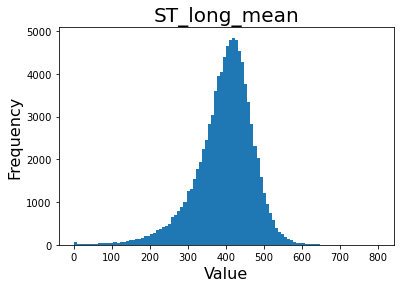

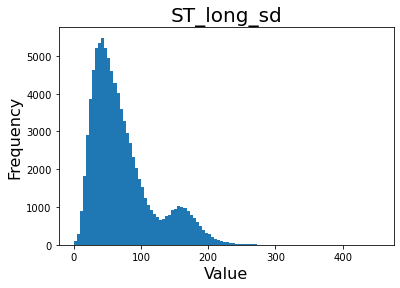

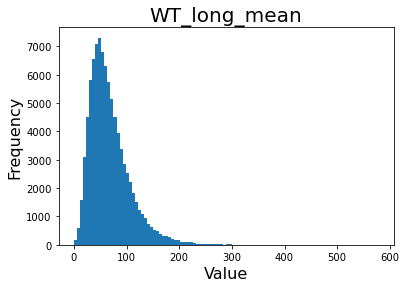

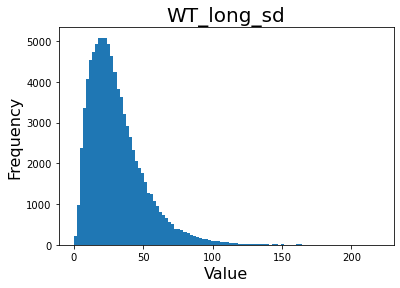

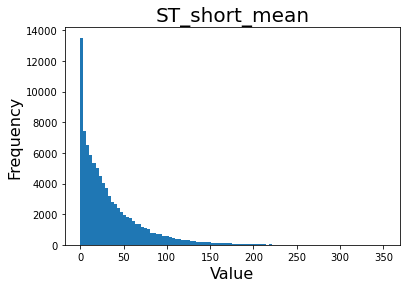

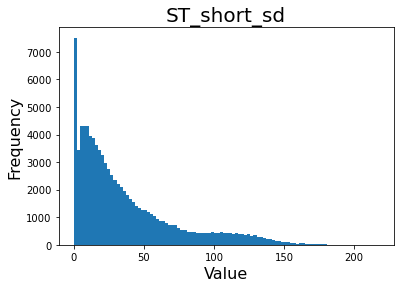

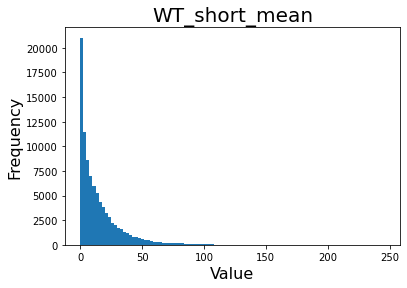

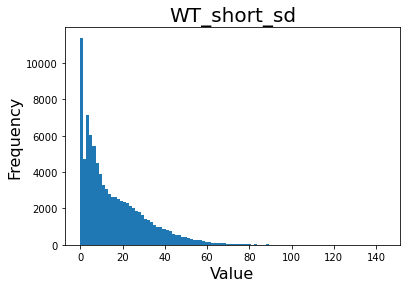

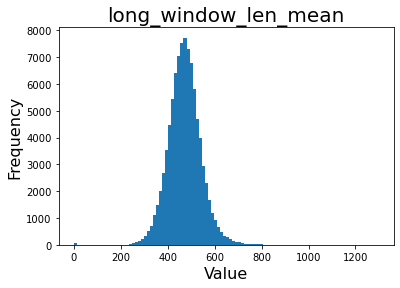

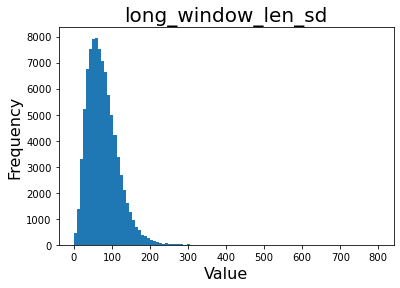

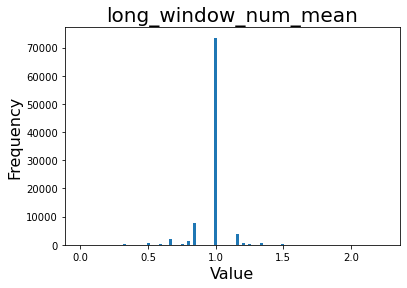

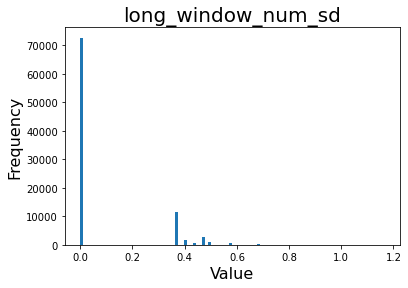

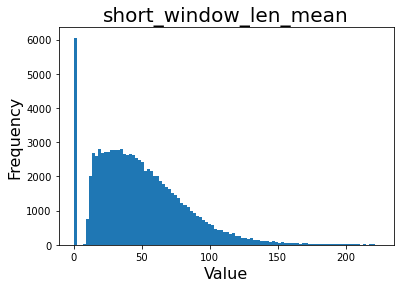

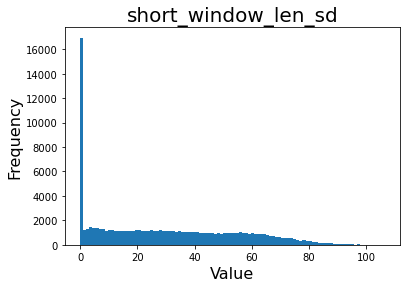

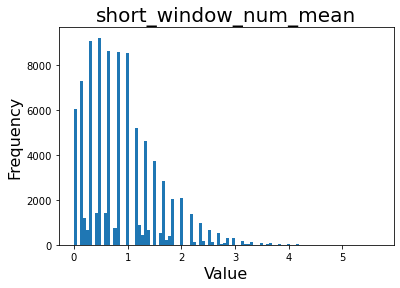

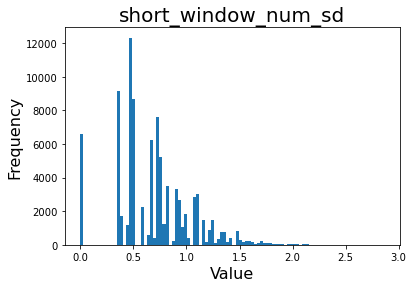

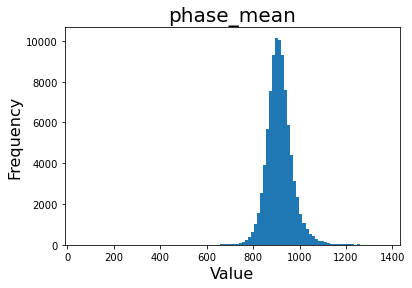

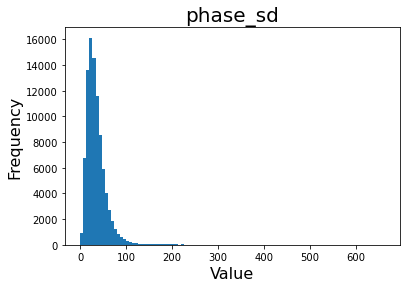

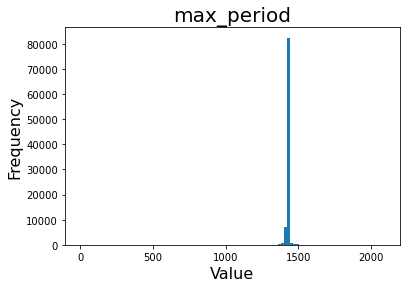

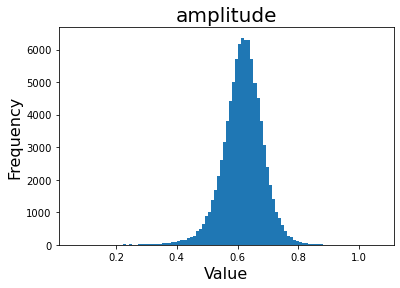

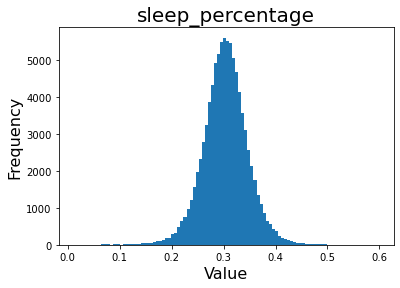

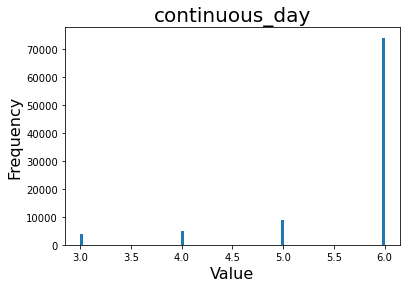

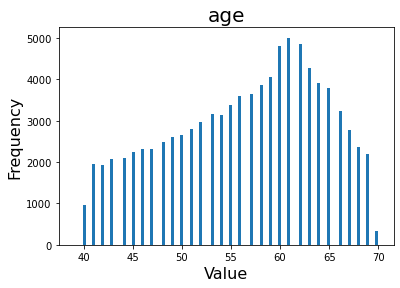

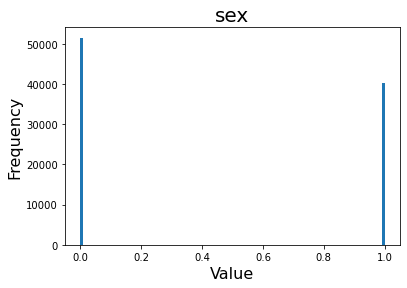

In [6]:
# Iterate over each float column and plot the histogram
for col_plot in columns_float32:
    plt.hist(df_onehot[col_plot].to_numpy(), bins=100)
    plt.title(col_plot, fontsize=20)
    plt.xlabel("Value", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    path_plot = os.path.join(dir_out_hist, col_plot + ".png")
    plt.savefig(path_plot, dpi=300,)
    plt.show()

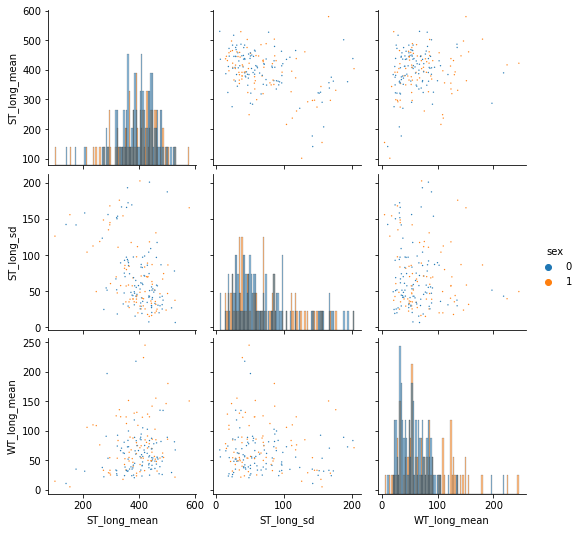

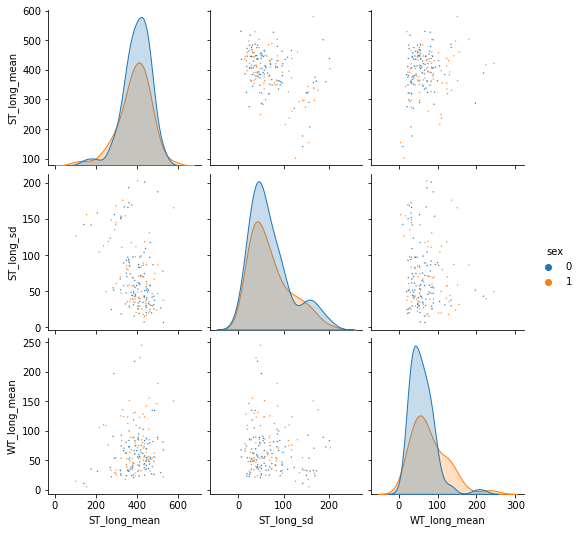

In [7]:
df_pandas = df_all[[ 'ST_long_mean',
 'ST_long_sd',
 'WT_long_mean',
 'sex',]].to_pandas()[::500]

df_pandas['sex'] = df_pandas['sex'].astype("int32").astype("category")

fig1 = sns.pairplot(df_pandas,
                    hue='sex',
                    diag_kind="hist",
                    plot_kws={"s":2}, 
                    diag_kws={'bins':100}
                   )

fig2 = sns.pairplot(df_pandas,
                    hue='sex',
                    diag_kind="kde",
                    plot_kws={"s":2}

                   )

**ATTENTION: This part takes many hours!**

In [ ]:
#sns.pairplot(df_all[columns_float32].to_pandas())
# df_pandas = df_all[[ 'ST_long_mean',
#  'ST_long_sd',
#  'WT_long_mean',
#  'WT_long_sd',]].to_pandas()[::100]

df_pandas = df_all[columns_float32].to_pandas()[::100]

fig1 = sns.pairplot(df_pandas)
path_plot = os.path.join(dir_out_plot, "pair_plot.png")
fig1.savefig(path_plot, dpi=300)

In [ ]:
col_onehot = ['sex',
 'group_eid_old_1',
 'group_eid_old_2a',
 'group_eid_old_2b',
 'group_eid_old_3a',
 'group_eid_old_3b',
 'group_eid_old_4a',
 'group_eid_old_4b',
 'group_eid_old_5',
 'group_eid_old_NA',
 'abnormal_group_eid_old_3b-1',
 'abnormal_group_eid_old_3b-2',
 'abnormal_group_eid_old_4b-1',
 'abnormal_group_eid_old_4b-2',
 'abnormal_group_eid_old_4b-3',
 'abnormal_group_eid_old_4b-4',
 'abnormal_group_eid_old_4b-5',
 'abnormal_group_eid_old_4b-6',
 'abnormal_group_eid_old_NA',
 'group_five_1',
 'group_five_2',
 'group_five_3',
 'group_five_4',
 'group_five_5',
 'group_five_NA']

for col_current in col_onehot:
    col_plot = ['ST_long_mean',
     'ST_long_sd'] + [col_current]

    #df_pandas = df_all[columns_float32].to_pandas()[::10000]
    df_pandas = df_onehot[col_plot].to_pandas()[::1000]

    fig1 = sns.pairplot(df_pandas,
                        hue=col_current,
                        diag_kind="kde",
                        plot_kws={"s":2}, 
                       )
    path_plot = os.path.join(dir_out_pairplot, col_current + ".png")
    fig1.savefig(path_plot, dpi=300)

# Dimension reduction

In [5]:
selected_columns = ['ST_long_mean', 'ST_long_sd', 'WT_long_mean', 'WT_long_sd',
                    'ST_short_mean', 'ST_short_sd', 'WT_short_mean', 'WT_short_sd',
                    'long_window_len_mean', 'long_window_len_sd', 
                    'long_window_num_mean', 'long_window_num_sd', 
                    'short_window_len_mean', 'short_window_len_sd', 
                    'short_window_num_mean', 'short_window_num_sd',
                    'phase_mean', 'phase_sd', 'max_period',
                    'amplitude', 'sleep_percentage']

df_selected = df_onehot[selected_columns]

## Simple PCA

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
df_std = scaler.fit_transform(df_selected)

# Conduct PCA
pca = PCA()
principalComponents = pca.fit_transform(df_std)

# Convert to DataFrame
df_pca = pd.DataFrame(data = principalComponents, columns = ['PC' + str(i) for i in range(1, len(selected_columns) + 1)])
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-0.094231,-0.164262,-0.997569,0.641520,0.392420,-0.622058,-0.587766,-0.316049,0.003180,-0.898068,...,0.560785,-0.392576,-0.295308,0.008569,0.019996,0.178232,-0.041602,-0.035421,-0.068207,-0.040494
1,4.713804,-3.838697,0.561880,-1.932946,0.659615,-0.929688,1.071669,1.187465,-1.615887,-0.746151,...,-0.311368,0.133059,0.117184,0.072801,0.184486,-0.530969,-0.537621,-0.124867,0.051443,-0.022361
2,-0.646244,4.079596,-0.450342,-0.581195,0.129869,0.533117,-1.177122,0.904382,-0.270163,-0.611315,...,0.347888,0.321854,-0.415456,0.398157,-0.114160,0.012536,0.011878,-0.031210,-0.055162,0.046739
3,-2.917400,0.284243,-0.491038,0.295121,-0.269551,0.578248,-0.442909,0.464142,-0.284259,0.448616,...,-0.194246,0.335224,-0.245552,-0.297294,-0.045786,0.066920,0.208592,-0.119385,-0.115406,-0.002868
4,-1.001521,-0.576554,-1.374343,-0.641147,0.598493,-1.267121,-0.379107,-0.394256,0.844535,-0.010711,...,0.262139,-0.427323,-0.327621,0.126767,0.112878,0.023128,-0.044858,-0.023029,-0.043659,0.027560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91739,2.658489,-2.211762,-1.552508,1.185735,0.409296,-0.092199,-1.270027,0.086540,0.247104,0.477901,...,-0.344975,0.220203,-0.133739,-0.093334,0.301978,-0.145081,0.055019,-0.014187,0.043949,-0.018773
91740,0.667909,-2.002607,1.268975,0.385212,0.730076,0.041659,0.726945,-1.181769,0.681190,-0.520374,...,0.155928,-0.793857,-0.384376,0.019968,0.065127,-0.056373,-0.077763,0.051357,0.007728,-0.027578
91741,-3.160785,-0.984509,0.305993,0.669452,0.041807,-0.305377,-0.259066,0.157419,-0.281930,1.035978,...,-0.227442,-0.078870,-0.814928,-0.143822,-0.316575,0.172046,-0.055785,0.011818,-0.007690,-0.013301
91742,-1.900336,-1.262394,0.842645,-0.436960,-0.881088,0.955735,0.523803,0.291759,-0.631460,-0.430837,...,0.025305,-0.011803,0.264540,0.003173,0.104470,0.057714,0.064160,0.060341,0.079374,-0.013523


In [7]:
df_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
count,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,...,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04,9.174400e+04
mean,5.886080e-17,-1.799901e-16,-6.738012e-17,-5.584031e-17,6.431316e-16,4.589593e-16,2.306801e-16,7.467576e-16,-3.976976e-17,-1.645004e-16,...,-3.314792e-16,6.303139e-16,2.418714e-16,2.025663e-16,-1.544515e-16,3.966763e-16,-7.249172e-17,-2.759584e-16,4.421336e-17,-2.777191e-17
std,2.652130e+00,1.931452e+00,1.379600e+00,1.181367e+00,1.005827e+00,9.947522e-01,9.845810e-01,9.324243e-01,8.741186e-01,7.070080e-01,...,6.385038e-01,5.525571e-01,5.307759e-01,3.482735e-01,2.998475e-01,2.664679e-01,2.318128e-01,1.154835e-01,9.559475e-02,3.000070e-02
min,-5.558018e+00,-1.401469e+01,-5.063485e+00,-9.679190e+00,-3.132469e+01,-1.677628e+01,-1.291465e+01,-5.479671e+00,-4.669413e+00,-4.058068e+00,...,-4.794533e+00,-2.983488e+00,-3.909478e+00,-3.874498e+00,-2.509441e+00,-2.500580e+00,-2.598495e+00,-3.136250e+00,-1.446090e+00,-2.383901e-01
25%,-1.951485e+00,-1.232111e+00,-8.643689e-01,-6.546835e-01,-3.461029e-01,-4.629043e-01,-4.942803e-01,-5.422322e-01,-4.780854e-01,-4.496173e-01,...,-3.571418e-01,-3.416555e-01,-3.118621e-01,-1.532599e-01,-1.409217e-01,-1.340127e-01,-1.008837e-01,-3.479953e-02,-4.697060e-02,-2.012247e-02
50%,-6.031806e-01,-2.184218e-01,-1.250926e-01,4.073474e-03,-2.231265e-02,5.829943e-02,-2.954547e-02,5.616882e-02,-3.169427e-02,-1.863889e-02,...,-4.451971e-02,-1.778882e-02,-9.768231e-03,-7.364195e-03,8.601077e-04,2.678383e-02,6.834026e-03,4.503373e-03,6.555414e-03,-3.984716e-03
75%,1.282166e+00,9.910041e-01,7.054022e-01,6.718600e-01,3.351243e-01,5.504147e-01,4.252340e-01,5.442453e-01,4.477894e-01,3.664129e-01,...,3.350654e-01,2.607003e-01,2.994999e-01,1.305275e-01,1.397812e-01,1.450353e-01,1.043164e-01,3.912228e-02,5.436090e-02,1.637954e-02
max,1.659733e+01,1.661805e+01,1.053196e+01,1.597350e+01,5.054148e+01,1.898485e+01,3.195100e+01,1.157903e+01,9.391228e+00,5.112519e+00,...,6.678686e+00,4.086677e+00,5.946840e+00,6.512002e+00,2.982135e+00,4.305699e+00,2.729418e+00,4.497511e+00,2.043304e+00,2.743255e-01


In [14]:
explained_variance = pca.explained_variance_ratio_.cumsum()
explained_variance

array([0.33493896, 0.51258015, 0.60321237, 0.66967011, 0.71784519,
       0.76496524, 0.81112664, 0.8525269 , 0.88891143, 0.91271405,
       0.93552215, 0.95493561, 0.96947447, 0.9828897 , 0.98866557,
       0.99294688, 0.99632804, 0.99888692, 0.99952199, 0.99995714,
       1.        ])

## Factor analysis (Oblimin rotation)
The `factor_analyzer` does not work by `from factor_analyzer import FactorAnalyzer`. Manually load the source code at the bottom of this notebook!

In [ ]:
# Select the columns for the analysis
df_selected = df_onehot[selected_columns].to_pandas()

In [17]:
calculate_kmo(df_selected)

(array([0.67753027, 0.76652457, 0.36880371, 0.81605502, 0.73557048,
        0.85876443, 0.79188206, 0.79971392, 0.55054033, 0.6156466 ,
        0.59166486, 0.83096197, 0.87156314, 0.91742078, 0.82257793,
        0.8379074 , 0.8827657 , 0.82175415, 0.23376733, 0.82447209,
        0.60351487]),
 0.7408587112257523)

In [29]:
def func_factoranalysis_results(fa):
    # Loading matrix
    factor_loadings = fa.loadings_
    print('Factor loadings:\n', np.round(factor_loadings, decimals=2))
    print()

    # Correlation matrix - huge
    corr_matrix = fa.corr_
    # print('Correlation matrix:\n', np.round(corr_matrix, decimals=2))
    # print()

    # Rotation matrix
    rot_matrix = fa.rotation_matrix_
    print('Rotation matrix:\n', np.round(rot_matrix, decimals=2))
    print()

    # Structure loading matrix
    try:
        structure_matrix = fa.structure_
        print('Structure matrix:\n', np.round(structure_matrix, decimals=2))
        print()
    except:
        pass

    # Factor correlations matrix
    try:
        factor_corr_matrix = fa.phi_
        print('Factor correlations matrix:\n', np.round(factor_corr_matrix, decimals=2))
        print()
    except:
        pass

    # Variance of each factor
    factor_variance = fa.get_factor_variance()
    print('Factor Variance:\n', np.round(factor_variance, decimals=2))
    print()

    # Uniquenesses of each variable
    uniquenesses = fa.get_uniquenesses()
    print('Uniquenesses:\n', np.round(uniquenesses, decimals=2))
    print()

    # Communalities of each variable
    communalities = fa.get_communalities()
    print('Communalities:\n', np.round(communalities, decimals=2))
    print()

    # Eigenvalues
    eigenvalues = fa.get_eigenvalues()
    print('Eigenvalues:\n', np.round(eigenvalues, decimals=2))
    print()
    
    # Sufficiency
    try:
        sufficiency = fa.sufficiency(df_selected.shape[0])
        print("Sufficiency test:\n", sufficiency)
    except Exception as e:
        print("Sufficiency test resulted in an error:")
        print(e)

In [37]:
# Initialize Factor Analyzer
fa = FactorAnalyzer(rotation='oblimin', n_factors=3, method="minres")

# Fit
fa.fit(df_selected)

# Display result
func_factoranalysis_results(fa)

Factor loadings:
 [[-0.4   0.84  0.05]
 [ 0.79 -0.01 -0.11]
 [-0.18 -0.06  0.83]
 [ 0.21  0.01  0.74]
 [ 0.91 -0.05 -0.01]
 [ 0.94 -0.   -0.17]
 [ 0.58  0.03  0.46]
 [ 0.58  0.05  0.45]
 [-0.22  0.61  0.29]
 [ 0.35  0.22  0.37]
 [-0.45  0.31  0.29]
 [ 0.66 -0.11  0.02]
 [ 0.68  0.02 -0.03]
 [ 0.8   0.04  0.07]
 [ 0.66 -0.    0.28]
 [ 0.65  0.02  0.17]
 [ 0.01 -0.1  -0.03]
 [ 0.16 -0.09  0.12]
 [-0.    0.   -0.  ]
 [ 0.14  1.03 -0.18]
 [ 0.08  1.    0.08]]

Rotation matrix:
 [[ 0.91 -0.24 -0.12]
 [ 0.26  0.83 -0.45]
 [ 0.4   0.57  0.91]]

Structure matrix:
 [[-0.56  0.93  0.13]
 [ 0.78 -0.17 -0.03]
 [-0.09  0.09  0.8 ]
 [ 0.29  0.07  0.76]
 [ 0.92 -0.23  0.07]
 [ 0.92 -0.21 -0.08]
 [ 0.62 -0.02  0.52]
 [ 0.61  0.    0.51]
 [-0.3   0.69  0.35]
 [ 0.34  0.2   0.43]
 [-0.48  0.44  0.29]
 [ 0.68 -0.24  0.07]
 [ 0.67 -0.12  0.04]
 [ 0.8  -0.1   0.16]
 [ 0.69 -0.09  0.35]
 [ 0.66 -0.08  0.24]
 [ 0.03 -0.11 -0.05]
 [ 0.19 -0.11  0.13]
 [-0.    0.   -0.  ]
 [-0.08  0.98 -0.02]
 [-0.1   0.99  0.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11776\4239340803.py:432: RuntimeWarning: invalid value encountered in sqrt
  sc = np.diag(1 / np.sqrt(psi))


In [38]:
# Initialize Factor Analyzer
fa = FactorAnalyzer(rotation='oblimin', n_factors=3, method="ml")

# Fit
fa.fit(df_selected)

# Display result
func_factoranalysis_results(fa)

Factor loadings:
 [[-0.41  0.83  0.05]
 [ 0.66 -0.05 -0.14]
 [-0.04 -0.09  0.94]
 [ 0.28  0.01  0.66]
 [ 1.   -0.01 -0.06]
 [ 0.83 -0.04 -0.14]
 [ 0.65  0.08  0.34]
 [ 0.54  0.06  0.34]
 [-0.19  0.63  0.4 ]
 [ 0.33  0.22  0.28]
 [-0.44  0.35  0.26]
 [ 0.61 -0.12 -0.01]
 [ 0.61 -0.01 -0.04]
 [ 0.71  0.02  0.03]
 [ 0.79  0.07  0.18]
 [ 0.6   0.02  0.1 ]
 [-0.   -0.11 -0.02]
 [ 0.16 -0.09  0.09]
 [-0.    0.   -0.  ]
 [ 0.11  1.02 -0.21]
 [ 0.11  1.    0.05]]

Rotation matrix:
 [[ 0.87 -0.35 -0.03]
 [ 0.54  0.96  0.06]
 [ 0.17 -0.02  1.01]]

Structure matrix:
 [[-0.57  0.92  0.18]
 [ 0.67 -0.2  -0.14]
 [-0.02  0.07  0.93]
 [ 0.28  0.06  0.66]
 [ 1.   -0.21 -0.05]
 [ 0.83 -0.23 -0.14]
 [ 0.63  0.    0.36]
 [ 0.54  0.    0.35]
 [-0.31  0.74  0.5 ]
 [ 0.29  0.2   0.32]
 [-0.5   0.48  0.32]
 [ 0.63 -0.24 -0.03]
 [ 0.61 -0.13 -0.04]
 [ 0.71 -0.12  0.04]
 [ 0.78 -0.06  0.19]
 [ 0.59 -0.08  0.11]
 [ 0.02 -0.11 -0.04]
 [ 0.18 -0.11  0.08]
 [-0.    0.   -0.  ]
 [-0.09  0.97 -0.04]
 [-0.09  0.99  0.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11776\4239340803.py:432: RuntimeWarning: invalid value encountered in sqrt
  sc = np.diag(1 / np.sqrt(psi))


In [39]:
# Initialize Factor Analyzer
fa = FactorAnalyzer(rotation='oblimin', n_factors=3, method="principal")

# Fit
fa.fit(df_selected)

# Display result
func_factoranalysis_results(fa)

Factor loadings:
 [[-0.37  0.85  0.02]
 [ 0.82 -0.   -0.13]
 [-0.21 -0.07  0.88]
 [ 0.2   0.    0.8 ]
 [ 0.9  -0.07 -0.01]
 [ 0.93 -0.02 -0.17]
 [ 0.59  0.02  0.49]
 [ 0.59  0.05  0.48]
 [-0.2   0.69  0.27]
 [ 0.37  0.25  0.44]
 [-0.48  0.35  0.35]
 [ 0.69 -0.13  0.02]
 [ 0.73  0.04 -0.07]
 [ 0.83  0.05  0.06]
 [ 0.68 -0.01  0.3 ]
 [ 0.68  0.03  0.18]
 [ 0.   -0.14 -0.03]
 [ 0.15 -0.15  0.2 ]
 [-0.    0.01 -0.  ]
 [ 0.14  1.01 -0.18]
 [ 0.09  0.99  0.05]]

Rotation matrix:
 [[ 0.91 -0.23  0.14]
 [ 0.21  0.8   0.5 ]
 [-0.43 -0.61  0.88]]

Structure matrix:
 [[-0.53  0.92  0.1 ]
 [ 0.81 -0.17 -0.04]
 [-0.1   0.09  0.85]
 [ 0.28  0.07  0.82]
 [ 0.92 -0.24  0.08]
 [ 0.92 -0.22 -0.07]
 [ 0.64 -0.02  0.56]
 [ 0.63  0.    0.55]
 [-0.3   0.76  0.34]
 [ 0.37  0.24  0.51]
 [-0.51  0.49  0.34]
 [ 0.71 -0.26  0.08]
 [ 0.72 -0.11  0.02]
 [ 0.82 -0.1   0.15]
 [ 0.72 -0.1   0.38]
 [ 0.7  -0.08  0.26]
 [ 0.03 -0.15 -0.05]
 [ 0.2  -0.15  0.2 ]
 [-0.    0.01 -0.  ]
 [-0.07  0.96 -0.03]
 [-0.09  0.98  0.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11776\4239340803.py:432: RuntimeWarning: invalid value encountered in sqrt
  sc = np.diag(1 / np.sqrt(psi))


### メモ: モデルの評価基準
- 因子の数
https://norimune.net/657
  - ガットマン基準：固有値が1以上の因子を採用する→今ではあまり良いとされない
  - スクリープロットとFactor loadingsを目視:とりあえずここから
  - その後、詰めたければMAPとかPAを用いるが、目で見て判断することが重要
- 回転は上記の議論に関係ない。後の話。


### その他未整理
- Confirmatory Factor Analysis (CFA) 
- Comparative Fit Index (CFI)
- Tucker-Lewis Index (TLI)
- Root Mean Square Error of Approximation (RMSEA)
- Standardized Root Mean Square Residual (SRMR)
- Akaike Information Criterion
- Bayesian Information Criterion
- Chi-square test　→ Irrelevant here (large N)
- Nested model comparison → Irrelevant here

### メモ: 条件検討
- n_factors (int, optional)–Thenumber of factors to select. Defaults to 3
- rotation (str, optional)– The type of rotation to perform after fitting the factor
 analysis model. If set to None, no rotation will be performed, nor will any associated Kaiser
 normalization.
 Possible values include:
 (a) varimax (orthogonal rotation)
 (b) promax (oblique rotation)
 (c) oblimin (oblique rotation)
 (d) oblimax (orthogonal rotation)
 (e) quartimin (oblique rotation)
 (f) quartimax (orthogonal rotation)
 (g) equamax (orthogonal rotation)

- method ({'minres', 'ml', 'principal'}, optional)– The fitting method
 to use, either MINRES or Maximum Likelihood. Defaults to ‘minres’



## `factor_analyzer` source code

In [9]:
"""
Class to perform various rotations of factor loading matrices.

:author: Jeremy Biggs (jeremy.m.biggs@gmail.com)
:author: Nitin Madnani (nmadnani@ets.org)
:organization: Educational Testing Service
:date: 2022-09-05
"""

import numpy as np
import scipy as sp
from sklearn.base import BaseEstimator

ORTHOGONAL_ROTATIONS = ["varimax", "oblimax", "quartimax", "equamax", "geomin_ort"]

OBLIQUE_ROTATIONS = ["promax", "oblimin", "quartimin", "geomin_obl"]

POSSIBLE_ROTATIONS = ORTHOGONAL_ROTATIONS + OBLIQUE_ROTATIONS


class Rotator(BaseEstimator):
    """
    Perform rotations on an unrotated factor loading matrix.

    The Rotator class takes an (unrotated) factor loading matrix and
    performs one of several rotations.

    Parameters
    ----------
    method : str, optional
        The factor rotation method. Options include:
            (a) varimax (orthogonal rotation)
            (b) promax (oblique rotation)
            (c) oblimin (oblique rotation)
            (d) oblimax (orthogonal rotation)
            (e) quartimin (oblique rotation)
            (f) quartimax (orthogonal rotation)
            (g) equamax (orthogonal rotation)
            (h) geomin_obl (oblique rotation)
            (i) geomin_ort (orthogonal rotation)

        Defaults to 'varimax'.
    normalize : bool or None, optional
        Whether to perform Kaiser normalization and de-normalization prior
        to and following rotation. Used for 'varimax' and 'promax' rotations.
        If ``None``, default for 'promax' is ``False``, and default for
        'varimax' is ``True``.
        Defaults to ``None``.
    power : int, optional
        The exponent to which to raise the promax loadings (minus 1).
        Numbers should generally range from 2 to 4.
        Defaults to 4.
    kappa : float, optional
        The kappa value for the 'equamax' objective. Ignored if the method
        is not 'equamax'.
        Defaults to 0.
    gamma : int, optional
        The gamma level for the 'oblimin' objective. Ignored if the method
        is not 'oblimin'.
        Defaults to 0.
    delta : float, optional
        The delta level for 'geomin' objectives. Ignored if the method is
        not 'geomin_*'.
        Defaults to 0.01.
    max_iter : int, optional
        The maximum number of iterations. Used for 'varimax' and 'oblique'
        rotations.
        Defaults to 1000.
    tol : float, optional
        The convergence threshold. Used for 'varimax' and 'oblique' rotations.
        Defaults to 1e-5.

    Attributes
    ----------
    loadings_ : :obj:`numpy.ndarray`, shape (``n_features``, ``n_factors``)
        The loadings matrix.
    rotation_ : :obj:`numpy.ndarray`, shape (``n_factors``, ``n_factors``)
        The rotation matrix.
    phi_ : :obj:`numpy.ndarray` or None
        The factor correlations matrix. This only exists if ``method`` is
        'oblique'.

    Notes
    -----
    Most of the rotations in this class are ported from R's ``GPARotation``
    package.

    References
    ----------
    [1] https://cran.r-project.org/web/packages/GPArotation/index.html

    Examples
    --------
    >>> import pandas as pd
    >>> from factor_analyzer import FactorAnalyzer, Rotator
    >>> df_features = pd.read_csv('test02.csv')
    >>> fa = FactorAnalyzer(rotation=None)
    >>> fa.fit(df_features)
    >>> rotator = Rotator()
    >>> rotator.fit_transform(fa.loadings_)
    array([[-0.07693215,  0.04499572,  0.76211208],
           [ 0.01842035,  0.05757874,  0.01297908],
           [ 0.06067925,  0.70692662, -0.03311798],
           [ 0.11314343,  0.84525117, -0.03407129],
           [ 0.15307233,  0.5553474 , -0.00121802],
           [ 0.77450832,  0.1474666 ,  0.20118338],
           [ 0.7063001 ,  0.17229555, -0.30093981],
           [ 0.83990851,  0.15058874, -0.06182469],
           [ 0.76620579,  0.1045194 , -0.22649615],
           [ 0.81372945,  0.20915845,  0.07479506]])
    """

    def __init__(
        self,
        method="varimax",
        normalize=True,
        power=4,
        kappa=0,
        gamma=0,
        delta=0.01,
        max_iter=500,
        tol=1e-5,
    ):
        """Initialize the rotator class."""
        self.method = method
        self.normalize = normalize
        self.power = power
        self.kappa = kappa
        self.gamma = gamma
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol

        self.loadings_ = None
        self.rotation_ = None
        self.phi_ = None

    def _oblimax_obj(self, loadings):  # noqa: D401
        """
        The Oblimax function objective.

        Parameters
        ----------
        loadings : array-like
            The loading matrix

        Returns
        -------
        gradient_dict : dict
            A dictionary containing the following keys:
            (1) ``grad`` : :obj:`numpy.ndarray`, containing the gradients.
            (2) ``criterion`` : float, containing the criterion for the objective.
        """
        gradient = -(
            4 * loadings**3 / (np.sum(loadings**4))
            - 4 * loadings / (np.sum(loadings**2))
        )
        criterion = np.log(np.sum(loadings**4)) - 2 * np.log(np.sum(loadings**2))
        return {"grad": gradient, "criterion": criterion}

    def _quartimax_obj(self, loadings):
        """
        Quartimax function objective.

        Parameters
        ----------
        loadings : array-like
            The loading matrix.

        Returns
        -------
        gradient_dict : dict
            A dictionary containing the following keys:
            (1) ``grad`` : :obj:`numpy.ndarray`, containing the gradients.
            (2) ``criterion`` : float, containing the criterion for the objective.
        """
        gradient = -(loadings**3)
        criterion = -np.sum(np.diag(np.dot((loadings**2).T, loadings**2))) / 4
        return {"grad": gradient, "criterion": criterion}

    def _oblimin_obj(self, loadings):  # noqa: D401
        """
        The Oblimin function objective.

        Parameters
        ----------
        loadings : array-like
            The loading matrix

        Returns
        -------
        gradient_dict : dict
            A dictionary containing the following keys:
            (1) ``grad`` : :obj:`numpy.ndarray`, containing the gradients.
            (2) ``criterion`` : float, containing the criterion for the objective.
        """
        X = np.dot(loadings**2, np.eye(loadings.shape[1]) != 1)
        if self.gamma != 0:
            p = loadings.shape[0]
            X = np.diag(np.full(1, p)) - np.dot(np.zeros((p, p)), X)
        gradient = loadings * X
        criterion = np.sum(loadings**2 * X) / 4
        return {"grad": gradient, "criterion": criterion}

    def _quartimin_obj(self, loadings):  # noqa: D401
        """
        The Quartimin function objective.

        Parameters
        ----------
        loadings : array-like
            The loading matrix.

        Returns
        -------
        gradient_dict : dict
            A dictionary containing the following keys:
            (1) ``grad`` : :obj:`numpy.ndarray`, containing the gradients.
            (2) ``criterion`` : float, containing the criterion for the objective.
        """
        X = np.dot(loadings**2, np.eye(loadings.shape[1]) != 1)
        gradient = loadings * X
        criterion = np.sum(loadings**2 * X) / 4
        return {"grad": gradient, "criterion": criterion}

    def _equamax_obj(self, loadings):  # noqa: D401
        """
        The Equamax function objective.

        Parameters
        ----------
        loadings : array-like
            The loading matrix.

        Returns
        -------
        gradient_dict : dict
            A dictionary containing the following keys:
            (1) ``grad`` : :obj:`numpy.ndarray`, containing the gradients.
            (2) ``criterion`` : float, containing the criterion for the objective.
        """
        p, k = loadings.shape

        N = np.ones(k) - np.eye(k)
        M = np.ones(p) - np.eye(p)

        loadings_squared = loadings**2
        f1 = (
            (1 - self.kappa)
            * np.sum(np.diag(np.dot(loadings_squared.T, np.dot(loadings_squared, N))))
            / 4
        )
        f2 = (
            self.kappa
            * np.sum(np.diag(np.dot(loadings_squared.T, np.dot(M, loadings_squared))))
            / 4
        )

        gradient = (1 - self.kappa) * loadings * np.dot(
            loadings_squared, N
        ) + self.kappa * loadings * np.dot(M, loadings_squared)

        criterion = f1 + f2
        return {"grad": gradient, "criterion": criterion}

    def _geomin_obj(self, loadings):  # noqa: D401
        """
        The Geomin function objective.

        Parameters
        ----------
        loadings : array-like
            The loading matrix.

        Returns
        -------
        gradient_dict : dict
            A dictionary containing the following keys:
            (1) ``grad`` : :obj:`numpy.ndarray`, containing the gradients.
            (2) ``criterion`` : float, containing the criterion for the objective.
        """
        p, k = loadings.shape

        loadings2 = loadings**2 + self.delta

        pro = np.exp(np.log(loadings2).sum(1) / k)
        rep = np.repeat(pro, k, axis=0).reshape(p, k)

        gradient = (2 / k) * (loadings / loadings2) * rep
        criterion = np.sum(pro)
        return {"grad": gradient, "criterion": criterion}

    def _oblique(self, loadings, method):
        """
        Perform oblique rotations, except 'promax'.

        A generic function for performing all oblique rotations, except for
        promax, which is implemented separately.

        Parameters
        ----------
        loadings : array-like
            The loading matrix
        method : str
            The obligue rotation method to use.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`, shape (``n_features``, ``n_factors``)
            The loadings matrix
        rotation_mtx : :obj:`numpy.ndarray`, shape (``n_factors``, ``n_factors``)
            The rotation matrix
        phi : :obj:`numpy.ndarray`, shape (``n_factors``, ``n_factors``)
            The factor correlations matrix. This only exists if the
            rotation is oblique.
        """
        if method == "oblimin":
            objective = self._oblimin_obj
        elif method == "quartimin":
            objective = self._quartimin_obj
        elif method == "geomin_obl":
            objective = self._geomin_obj

        # initialize the rotation matrix
        _, n_cols = loadings.shape
        rotation_matrix = np.eye(n_cols)

        # default alpha level
        alpha = 1
        rotation_matrix_inv = np.linalg.inv(rotation_matrix)
        new_loadings = np.dot(loadings, rotation_matrix_inv.T)

        obj = objective(new_loadings)
        gradient = -np.dot(new_loadings.T, np.dot(obj["grad"], rotation_matrix_inv)).T
        criterion = obj["criterion"]

        obj_t = objective(new_loadings)

        # main iteration loop, up to `max_iter`, calculate the gradient
        for _ in range(0, self.max_iter + 1):
            gradient_new = gradient - np.dot(
                rotation_matrix,
                np.diag(np.dot(np.ones(gradient.shape[0]), rotation_matrix * gradient)),
            )
            s = np.sqrt(np.sum(np.diag(np.dot(gradient_new.T, gradient_new))))

            if s < self.tol:
                break

            alpha = 2 * alpha

            # calculate the Hessian of the objective function
            for _ in range(0, 11):
                X = rotation_matrix - alpha * gradient_new

                v = 1 / np.sqrt(np.dot(np.ones(X.shape[0]), X**2))
                new_rotation_matrix = np.dot(X, np.diag(v))
                new_loadings = np.dot(loadings, np.linalg.inv(new_rotation_matrix).T)

                obj_t = objective(new_loadings)
                improvement = criterion - obj_t["criterion"]

                if improvement > 0.5 * s**2 * alpha:
                    break

                alpha = alpha / 2

            rotation_matrix = new_rotation_matrix
            criterion = obj_t["criterion"]
            gradient = -np.dot(
                np.dot(new_loadings.T, obj_t["grad"]),
                np.linalg.inv(new_rotation_matrix),
            ).T

        # calculate phi
        phi = np.dot(rotation_matrix.T, rotation_matrix)

        # convert loadings matrix to data frame
        loadings = new_loadings.copy()
        return loadings, rotation_matrix, phi

    def _orthogonal(self, loadings, method):
        """
        Perform orthogonal rotations, except 'varimax'.

        A generic function for performing all orthogonal rotations, except for
        varimax, which is implemented separately.

        Parameters
        ----------
        loadings : :obj:`numpy.ndarray`
            The loading matrix
        method : str
            The orthogonal rotation method to use.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`
            The loadings matrix
        rotation_mtx : :obj:`numpy.ndarray`, shape (``n_factors``, ``n_factors``)
            The rotation matrix
        """
        if method == "oblimax":
            objective = self._oblimax_obj
        elif method == "quartimax":
            objective = self._quartimax_obj
        elif method == "equamax":
            objective = self._equamax_obj
        elif method == "geomin_ort":
            objective = self._geomin_obj

        arr = loadings.copy()

        # initialize the rotation matrix
        _, n_cols = arr.shape
        rotation_matrix = np.eye(n_cols)

        # default alpha level
        alpha = 1
        new_loadings = np.dot(arr, rotation_matrix)

        obj = objective(new_loadings)
        gradient = np.dot(arr.T, obj["grad"])
        criterion = obj["criterion"]

        obj_t = objective(new_loadings)

        # main iteration loop, up to `max_iter`, calculate the gradient
        for _ in range(0, self.max_iter + 1):
            M = np.dot(rotation_matrix.T, gradient)
            S = (M + M.T) / 2
            gradient_new = gradient - np.dot(rotation_matrix, S)
            s = np.sqrt(np.sum(np.diag(np.dot(gradient_new.T, gradient_new))))

            if s < self.tol:
                break

            alpha = 2 * alpha

            # calculate the Hessian of the objective function
            for _ in range(0, 11):
                X = rotation_matrix - alpha * gradient_new
                U, _, V = np.linalg.svd(X)
                new_rotation_matrix = np.dot(U, V)
                new_loadings = np.dot(arr, new_rotation_matrix)

                obj_t = objective(new_loadings)

                if obj_t["criterion"] < (criterion - 0.5 * s**2 * alpha):
                    break

                alpha = alpha / 2

            rotation_matrix = new_rotation_matrix
            criterion = obj_t["criterion"]
            gradient = np.dot(arr.T, obj_t["grad"])

        # convert loadings matrix to data frame
        loadings = new_loadings.copy()
        return loadings, rotation_matrix

    def _varimax(self, loadings):
        """
        Perform varimax (orthogonal) rotation, with optional Kaiser normalization.

        Parameters
        ----------
        loadings : array-like
            The loading matrix.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`, shape (``n_features``, ``n_factors``)
            The loadings matrix.
        rotation_mtx : :obj:`numpy.ndarray`, shape (``n_factors``, ``n_factors``)
            The rotation matrix.
        """
        X = loadings.copy()
        n_rows, n_cols = X.shape
        if n_cols < 2:
            return X

        # normalize the loadings matrix
        # using sqrt of the sum of squares (Kaiser)
        if self.normalize:
            normalized_mtx = np.apply_along_axis(
                lambda x: np.sqrt(np.sum(x**2)), 1, X.copy()
            )
            X = (X.T / normalized_mtx).T

        # initialize the rotation matrix
        # to N x N identity matrix
        rotation_mtx = np.eye(n_cols)

        d = 0
        for _ in range(self.max_iter):

            old_d = d

            # take inner product of loading matrix
            # and rotation matrix
            basis = np.dot(X, rotation_mtx)

            # transform data for singular value decomposition using updated formula :
            # B <- t(x) %*% (z^3 - z %*% diag(drop(rep(1, p) %*% z^2))/p)
            diagonal = np.diag(np.squeeze(np.repeat(1, n_rows).dot(basis**2)))
            transformed = X.T.dot(basis**3 - basis.dot(diagonal) / n_rows)

            # perform SVD on
            # the transformed matrix
            U, S, V = np.linalg.svd(transformed)

            # take inner product of U and V, and sum of S
            rotation_mtx = np.dot(U, V)
            d = np.sum(S)

            # check convergence
            if d < old_d * (1 + self.tol):
                break

        # take inner product of loading matrix
        # and rotation matrix
        X = np.dot(X, rotation_mtx)

        # de-normalize the data
        if self.normalize:
            X = X.T * normalized_mtx
        else:
            X = X.T

        # convert loadings matrix to data frame
        loadings = X.T.copy()
        return loadings, rotation_mtx

    def _promax(self, loadings):
        """
        Perform promax (oblique) rotation, with optional Kaiser normalization.

        Parameters
        ----------
        loadings : array-like
            The loading matrix

        Returns
        -------
        loadings : :obj:`numpy.ndarray`, shape (``n_features``, ``n_factors``)
            The loadings matrix
        rotation_mtx : :obj:`numpy.ndarray`, shape (``n_factors``, ``n_factors``)
            The rotation matrix
        phi : :obj:`numpy.ndarray` or None, shape (``n_factors``, ``n_factors``)
            The factor correlations matrix. This only exists if the rotation
            is oblique.
        """
        X = loadings.copy()
        _, n_cols = X.shape
        if n_cols < 2:
            return X

        if self.normalize:
            # pre-normalization is done in R's
            # `kaiser()` function when rotate='Promax'.
            array = X.copy()
            h2 = sp.diag(np.dot(array, array.T))
            h2 = np.reshape(h2, (h2.shape[0], 1))
            weights = array / sp.sqrt(h2)

        else:
            weights = X.copy()

        # first get varimax rotation
        X, rotation_mtx = self._varimax(weights)
        Y = X * np.abs(X) ** (self.power - 1)

        # fit linear regression model
        coef = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))

        # calculate diagonal of inverse square
        try:
            diag_inv = sp.diag(sp.linalg.inv(sp.dot(coef.T, coef)))
        except np.linalg.LinAlgError:
            diag_inv = sp.diag(sp.linalg.pinv(sp.dot(coef.T, coef)))

        # transform and calculate inner products
        coef = sp.dot(coef, sp.diag(sp.sqrt(diag_inv)))
        z = sp.dot(X, coef)

        if self.normalize:
            # post-normalization is done in R's
            # `kaiser()` function when rotate='Promax'
            z = z * sp.sqrt(h2)

        rotation_mtx = sp.dot(rotation_mtx, coef)

        coef_inv = np.linalg.inv(coef)
        phi = np.dot(coef_inv, coef_inv.T)

        # convert loadings matrix to data frame
        loadings = z.copy()
        return loadings, rotation_mtx, phi

    def fit(self, X, y=None):
        """
        Compute the factor rotation.

        Parameters
        ----------
        X : array-like
            The factor loading matrix, shape (``n_features``, ``n_factors``)
        y : ignored

        Returns
        -------
        self

        Example
        -------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer, Rotator
        >>> df_features = pd.read_csv('test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        >>> rotator = Rotator()
        >>> rotator.fit(fa.loadings_)
        """
        self.fit_transform(X)
        return self

    def fit_transform(self, X, y=None):
        """
        Compute the factor rotation, and return the new loading matrix.

        Parameters
        ----------
        X : array-like
            The factor loading matrix, shape (``n_features``, ``n_factors``)
        y : Ignored

        Returns
        -------
        loadings_ : :obj:`numpy,ndarray`, shape (``n_features``, ``n_factors``)
            The loadings matrix.

        Raises
        ------
        ValueError
            If ``method`` is not in the list of acceptable methods.

        Example
        -------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer, Rotator
        >>> df_features = pd.read_csv('test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        >>> rotator = Rotator()
        >>> rotator.fit_transform(fa.loadings_)
        array([[-0.07693215,  0.04499572,  0.76211208],
               [ 0.01842035,  0.05757874,  0.01297908],
               [ 0.06067925,  0.70692662, -0.03311798],
               [ 0.11314343,  0.84525117, -0.03407129],
               [ 0.15307233,  0.5553474 , -0.00121802],
               [ 0.77450832,  0.1474666 ,  0.20118338],
               [ 0.7063001 ,  0.17229555, -0.30093981],
               [ 0.83990851,  0.15058874, -0.06182469],
               [ 0.76620579,  0.1045194 , -0.22649615],
               [ 0.81372945,  0.20915845,  0.07479506]])
        """
        # default phi to None
        # it will only be calculated
        # for oblique rotations
        phi = None
        method = self.method.lower()
        if method == "varimax":
            (new_loadings, new_rotation_mtx) = self._varimax(X)

        elif method == "promax":
            (new_loadings, new_rotation_mtx, phi) = self._promax(X)

        elif method in OBLIQUE_ROTATIONS:
            (new_loadings, new_rotation_mtx, phi) = self._oblique(X, method)

        elif method in ORTHOGONAL_ROTATIONS:
            (new_loadings, new_rotation_mtx) = self._orthogonal(X, method)

        else:
            raise ValueError(
                "The value for `method` must be one of the "
                "following: {}.".format(", ".join(POSSIBLE_ROTATIONS))
            )

        (self.loadings_, self.rotation_, self.phi_) = (
            new_loadings,
            new_rotation_mtx,
            phi,
        )
        return self.loadings_

print("rotator is loaded successfully")

rotator is loaded successfully


In [10]:
"""
Utility functions, used primarily by the confirmatory factor analysis module.

:author: Jeremy Biggs (jeremy.m.biggs@gmail.com)
:author: Nitin Madnani (nmadnani@ets.org)
:organization: Educational Testing Service
:date: 2022-09-05
"""
import warnings

import numpy as np
from scipy.linalg import cholesky


def inv_chol(x, logdet=False):
    """
    Calculate matrix inverse using Cholesky decomposition.

    Optionally, calculate the log determinant of the Cholesky.

    Parameters
    ----------
    x : array-like
        The matrix to invert.
    logdet : bool, optional
        Whether to calculate the log determinant, instead of the inverse.
        Defaults to ``False``.

    Returns
    -------
    chol_inv : array-like
        The inverted matrix.
    chol_logdet : array-like or None
        The log determinant, if ``logdet`` was ``True``, otherwise, ``None``.

    """
    chol = cholesky(x, lower=True)

    chol_inv = np.linalg.inv(chol)
    chol_inv = np.dot(chol_inv.T, chol_inv)
    chol_logdet = None

    if logdet:
        chol_diag = np.diag(chol)
        chol_logdet = np.sum(np.log(chol_diag * chol_diag))

    return chol_inv, chol_logdet


def cov(x, ddof=0):
    """
    Calculate the covariance matrix.

    Parameters
    ----------
    x : array-like
        A 1-D or 2-D array containing multiple variables
        and observations. Each column of x represents a variable,
        and each row a single observation of all those variables.
    ddof : int, optional
        Means Delta Degrees of Freedom. The divisor used in calculations
        is N - ddof, where N represents the number of elements.
        Defaults to 0.

    Returns
    -------
    r : numpy array
        The covariance matrix of the variables.
    """
    r = np.cov(x, rowvar=False, ddof=ddof)
    return r


def corr(x):
    """
    Calculate the correlation matrix.

    Parameters
    ----------
    x : array-like
        A 1-D or 2-D array containing multiple variables
        and observations. Each column of x represents a variable,
        and each row a single observation of all those variables.

    Returns
    -------
    r : numpy array
        The correlation matrix of the variables.
    """
    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0, ddof=0)
    r = cov(x)
    return r


def apply_impute_nan(x, how="mean"):
    """
    Apply a function to impute ``np.nan`` values with the mean or the median.

    Parameters
    ----------
    x : array-like
        The 1-D array to impute.
    how : str, optional
        Whether to impute the 'mean' or 'median'.
        Defaults to 'mean'.

    Returns
    -------
    x : :obj:`numpy.ndarray`
        The array, with the missing values imputed.
    """
    if how == "mean":
        x[np.isnan(x)] = np.nanmean(x)
    elif how == "median":
        x[np.isnan(x)] = np.nanmedian(x)
    return x


def impute_values(x, how="mean"):
    """
    Impute ``np.nan`` values with the mean or median, or drop the containing rows.

    Parameters
    ----------
    x : array-like
        An array to impute.
    how : str, optional
        Whether to impute the 'mean' or 'median'.
        Defaults to 'mean'.

    Returns
    -------
    x : :obj:`numpy.ndarray`
        The array, with the missing values imputed or with rows dropped.
    """
    # impute mean or median, if `how` is set to 'mean' or 'median'
    if how in ["mean", "median"]:
        x = np.apply_along_axis(apply_impute_nan, 0, x, how=how)
    # drop missing if `how` is set to 'drop'
    elif how == "drop":
        x = x[~np.isnan(x).any(1), :].copy()
    return x


def smc(corr_mtx, sort=False):
    """
    Calculate the squared multiple correlations.

    This is equivalent to regressing each variable on all others and
    calculating the r-squared values.

    Parameters
    ----------
    corr_mtx : array-like
        The correlation matrix used to calculate SMC.
    sort : bool, optional
        Whether to sort the values for SMC before returning.
        Defaults to ``False``.

    Returns
    -------
    smc : :obj:`numpy.ndarray`
        The squared multiple correlations matrix.
    """
    corr_inv = np.linalg.inv(corr_mtx)
    smc = 1 - 1 / np.diag(corr_inv)

    if sort:
        smc = np.sort(smc)
    return smc


def covariance_to_correlation(m):
    """
    Compute cross-correlations from the given covariance matrix.

    This is a port of R ``cov2cor()`` function.

    Parameters
    ----------
    m : array-like
        The covariance matrix.

    Returns
    -------
    retval : :obj:`numpy.ndarray`
        The cross-correlation matrix.

    Raises
    ------
    ValueError
        If the input matrix is not square.
    """
    # make sure the matrix is square
    numrows, numcols = m.shape
    if not numrows == numcols:
        raise ValueError("Input matrix must be square")

    Is = np.sqrt(1 / np.diag(m))
    retval = Is * m * np.repeat(Is, numrows).reshape(numrows, numrows)
    np.fill_diagonal(retval, 1.0)
    return retval


def partial_correlations(x):
    """
    Compute partial correlations between variable pairs.

    This is a python port of the ``pcor()`` function implemented in
    the ``ppcor`` R package, which computes partial correlations
    for each pair of variables in the given array, excluding all
    other variables.

    Parameters
    ----------
    x : array-like
        An array containing the feature values.

    Returns
    -------
    pcor : :obj:`numpy.ndarray`
        An array containing the partial correlations of of each
        pair of variables in the given array, excluding all other
        variables.
    """
    numrows, numcols = x.shape
    x_cov = cov(x, ddof=1)
    # create empty array for when we cannot compute the
    # matrix inversion
    empty_array = np.empty((numcols, numcols))
    empty_array[:] = np.nan
    if numcols > numrows:
        icvx = empty_array
    else:
        # if the determinant is less than the lowest representable
        # 32 bit integer, then we use the pseudo-inverse;
        # otherwise, use the inverse; if a linear algebra error
        # occurs, then we just set the matrix to empty
        try:
            assert np.linalg.det(x_cov) > np.finfo(np.float32).eps
            icvx = np.linalg.inv(x_cov)
        except AssertionError:
            icvx = np.linalg.pinv(x_cov)
            warnings.warn(
                "The inverse of the variance-covariance matrix "
                "was calculated using the Moore-Penrose generalized "
                "matrix inversion, due to its determinant being at "
                "or very close to zero."
            )
        except np.linalg.LinAlgError:
            icvx = empty_array

    pcor = -1 * covariance_to_correlation(icvx)
    np.fill_diagonal(pcor, 1.0)
    return pcor


def unique_elements(seq):
    """
    Get first unique instance of every list element, while maintaining order.

    Parameters
    ----------
    seq : list-like
        The list of elements.

    Returns
    -------
    seq : list
        The updated list of elements.
    """
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]


def fill_lower_diag(x):
    """
    Fill the lower diagonal of a square matrix, given a 1-D input array.

    Parameters
    ----------
    x : array-like
        The flattened input matrix that will be used to fill the lower
        diagonal of the square matrix.

    Returns
    -------
    out : :obj:`numpy.ndarray`
        The output square matrix, with the lower diagonal filled by x.

    References
    ----------
    [1] https://stackoverflow.com/questions/51439271/
        convert-1d-array-to-lower-triangular-matrix
    """
    x = np.array(x)
    x = x if len(x.shape) == 1 else np.squeeze(x, axis=1)
    n = int(np.sqrt(len(x) * 2)) + 1
    out = np.zeros((n, n), dtype=float)
    out[np.tri(n, dtype=bool, k=-1)] = x
    return out


def merge_variance_covariance(variances, covariances=None):
    """
    Merge variances and covariances into a single variance-covariance matrix.

    Parameters
    ----------
    variances : array-like
        The variances that will be used to fill the diagonal of the
        square matrix.
    covariances : array-like or None, optional
        The flattened input matrix that will be used to fill the lower and
        upper diagonal of the square matrix. If None, then only the variances
        will be used.
        Defaults to ``None``.

    Returns
    -------
    variance_covariance : :obj:`numpy.ndarray`
        The variance-covariance matrix.
    """
    variances = (
        variances if len(variances.shape) == 1 else np.squeeze(variances, axis=1)
    )
    if covariances is None:
        variance_covariance = np.zeros((variances.shape[0], variances.shape[0]))
    else:
        variance_covariance = fill_lower_diag(covariances)
        variance_covariance += variance_covariance.T
    np.fill_diagonal(variance_covariance, variances)
    return variance_covariance


def get_first_idxs_from_values(x, eq=1, use_columns=True):
    """
    Get the indexes  for a given value.

    Parameters
    ----------
    x : array-like
        The input matrix.
    eq : str or int, optional
        The given value to find.
        Defaults to 1.
    use_columns : bool, optional
        Whether to get the first indexes using the columns.
        If ``False``, then use the rows instead.
        Defaults to ``True``.

    Returns
    -------
    row_idx : list
        A list of row indexes.
    col_idx : list
        A list of column indexes.
    """
    x = np.array(x)
    if use_columns:
        n = x.shape[1]
        row_idx = [np.where(x[:, i] == eq)[0][0] for i in range(n)]
        col_idx = list(range(n))
    else:
        n = x.shape[0]
        col_idx = [np.where(x[i, :] == eq)[0][0] for i in range(n)]
        row_idx = list(range(n))
    return row_idx, col_idx


def get_free_parameter_idxs(x, eq=1):
    """
    Get the free parameter indices from the flattened matrix.

    Parameters
    ----------
    x : array-like
        The input matrix.
    eq : str or int, optional
        The value that free parameters should be equal to. ``np.nan`` fields
        will be populated with this value.
        Defaults to 1.

    Returns
    -------
    idx : :obj:`numpy.ndarray`
        The free parameter indexes.
    """
    x[np.isnan(x)] = eq
    x = x.flatten(order="F")
    return np.where(x == eq)[0]


def duplication_matrix(n=1):
    """
    Calculate the duplication matrix.

    A function to create the duplication matrix (Dn), which is
    the unique n2 × n(n+1)/2 matrix which, for any n × n symmetric
    matrix A, transforms vech(A) into vec(A), as in Dn vech(A) = vec(A).

    Parameters
    ----------
    n : int, optional
        The dimension of the n x n symmetric matrix.
        Defaults to 1.

    Returns
    -------
    duplication_matrix : :obj:`numpy.ndarray`
        The duplication matrix.

    Raises`
    ------
    ValueError
        If ``n`` is not a positive integer greater than 1.

    References
    ----------
    https://en.wikipedia.org/wiki/Duplication_and_elimination_matrices
    """
    if n < 1:
        raise ValueError(
            "The argument `n` must be a " "positive integer greater than 1."
        )

    dup = np.zeros((int(n * n), int(n * (n + 1) / 2)))
    count = 0
    for j in range(n):
        dup[j * n + j, count + j] = 1
        if j < n - 1:
            for i in range(j + 1, n):
                dup[j * n + i, count + i] = 1
                dup[i * n + j, count + i] = 1
        count += n - j - 1
    return dup


def duplication_matrix_pre_post(x):
    """
    Transform given input symmetric matrix using pre-post duplication.

    Parameters
    ----------
    x : array-like
        The input matrix.

    Returns
    -------
    out : :obj:`numpy.ndarray`
        The transformed matrix.

    Raises
    ------
    AssertionError
        If ``x`` is not symmetric.
    """
    assert x.shape[0] == x.shape[1]

    n2 = x.shape[1]
    n = int(np.sqrt(n2))

    idx1 = get_symmetric_lower_idxs(n)
    idx2 = get_symmetric_upper_idxs(n)

    out = x[idx1, :] + x[idx2, :]
    u = np.where([i in idx2 for i in idx1])[0]
    out[u, :] = out[u, :] / 2.0
    out = out[:, idx1] + out[:, idx2]
    out[:, u] = out[:, u] / 2.0
    return out


def commutation_matrix(p, q):
    """
    Calculate the commutation matrix.

    This matrix transforms the vectorized form of the matrix into the
    vectorized form of its transpose.

    Parameters
    ----------
    p : int
        The number of rows.
    q : int
        The number of columns.

    Returns
    -------
    commutation_matrix : :obj:`numpy.ndarray`
        The commutation matrix

    References
    ----------
    https://en.wikipedia.org/wiki/Commutation_matrix
    """
    identity = np.eye(p * q)
    indices = np.arange(p * q).reshape((p, q), order="F")
    return identity.take(indices.ravel(), axis=0)


def get_symmetric_lower_idxs(n=1, diag=True):
    """
    Get the indices for the lower triangle of a symmetric matrix.

    Parameters
    ----------
    n : int, optional
        The dimension of the n x n symmetric matrix.
        Defaults to 1.
    diag : bool, optional
        Whether to include the diagonal.

    Returns
    -------
    indices : :obj:`numpy.ndarray`
        The indices for the lower triangle.
    """
    rows = np.repeat(np.arange(n), n).reshape(n, n)
    cols = rows.T
    if diag:
        return np.where((rows >= cols).T.flatten())[0]
    return np.where((cols > rows).T.flatten())[0]


def get_symmetric_upper_idxs(n=1, diag=True):
    """
    Get the indices for the upper triangle of a symmetric matrix.

    Parameters
    ----------
    n : int, optional
        The dimension of the n x n symmetric matrix.
        Defaults to 1.
    diag : bool, optional
        Whether to include the diagonal.

    Returns
    -------
    indices : :obj:`numpy.ndarray`
        The indices for the upper triangle.
    """
    rows = np.repeat(np.arange(n), n).reshape(n, n)
    cols = rows.T
    temp = np.arange(n * n).reshape(n, n)
    if diag:
        return temp.T[(rows >= cols).T]
    return temp.T[(cols > rows).T]

print("utils are loaded successfully")

utils are loaded successfully


In [11]:
"""
Factor analysis using MINRES or ML, with optional rotation using Varimax or Promax.

:author: Jeremy Biggs (jeremy.m.biggs@gmail.com)
:author: Nitin Madnani (nmadnani@ets.org)
:organization: Educational Testing Service
:date: 2022-09-05
"""

import warnings
from typing import Tuple

import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import chi2, pearsonr
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.extmath import randomized_svd
from sklearn.utils.validation import check_is_fitted

POSSIBLE_SVDS = ["randomized", "lapack"]

POSSIBLE_IMPUTATIONS = ["mean", "median", "drop"]

POSSIBLE_METHODS = ["ml", "mle", "uls", "minres", "principal"]


def calculate_kmo(x):
    """
    Calculate the Kaiser-Meyer-Olkin criterion for items and overall.

    This statistic represents the degree to which each observed variable is
    predicted, without error, by the other variables in the dataset.
    In general, a KMO < 0.6 is considered inadequate.

    Parameters
    ----------
    x : array-like
        The array from which to calculate KMOs.

    Returns
    -------
    kmo_per_variable : :obj:`numpy.ndarray`
        The KMO score per item.
    kmo_total : float
        The overall KMO score.
    """
    # calculate the partial correlations
    partial_corr = partial_correlations(x)

    # calcualte the pair-wise correlations
    x_corr = corr(x)

    # fill matrix diagonals with zeros
    # and square all elements
    np.fill_diagonal(x_corr, 0)
    np.fill_diagonal(partial_corr, 0)

    partial_corr = partial_corr**2
    x_corr = x_corr**2

    # calculate KMO per item
    partial_corr_sum = np.sum(partial_corr, axis=0)
    corr_sum = np.sum(x_corr, axis=0)
    kmo_per_item = corr_sum / (corr_sum + partial_corr_sum)

    # calculate KMO overall
    corr_sum_total = np.sum(x_corr)
    partial_corr_sum_total = np.sum(partial_corr)
    kmo_total = corr_sum_total / (corr_sum_total + partial_corr_sum_total)
    return kmo_per_item, kmo_total


def calculate_bartlett_sphericity(x):
    """
    Compute the Bartlett sphericity test.

    H0: The matrix of population correlations is equal to I.
    H1: The matrix of population correlations is not equal to I.

    The formula for Bartlett's Sphericity test is:

    .. math:: -1 * (n - 1 - ((2p + 5) / 6)) * ln(det(R))

    Where R det(R) is the determinant of the correlation matrix,
    and p is the number of variables.

    Parameters
    ----------
    x : array-like
        The array for which to calculate sphericity.

    Returns
    -------
    statistic : float
        The chi-square value.
    p_value : float
        The associated p-value for the test.
    """
    n, p = x.shape
    x_corr = corr(x)

    corr_det = np.linalg.det(x_corr)
    statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
    degrees_of_freedom = p * (p - 1) / 2
    p_value = chi2.sf(statistic, degrees_of_freedom)
    return statistic, p_value


class FactorAnalyzer(BaseEstimator, TransformerMixin):
    """
    The main exploratory factor analysis class.

    This class:
        (1) Fits a factor analysis model using minres, maximum likelihood,
            or principal factor extraction and returns the loading matrix
        (2) Optionally performs a rotation, with method including:

            (a) varimax (orthogonal rotation)
            (b) promax (oblique rotation)
            (c) oblimin (oblique rotation)
            (d) oblimax (orthogonal rotation)
            (e) quartimin (oblique rotation)
            (f) quartimax (orthogonal rotation)
            (g) equamax (orthogonal rotation)

    Parameters
    ----------
    n_factors : int, optional
        The number of factors to select.
        Defaults to 3.
    rotation : str, optional
        The type of rotation to perform after fitting the factor analysis
        model. If set to ``None``, no rotation will be performed, nor will
        any associated Kaiser normalization.

        Possible values include:

            (a) varimax (orthogonal rotation)
            (b) promax (oblique rotation)
            (c) oblimin (oblique rotation)
            (d) oblimax (orthogonal rotation)
            (e) quartimin (oblique rotation)
            (f) quartimax (orthogonal rotation)
            (g) equamax (orthogonal rotation)

        Defaults to 'promax'.

    method : {'minres', 'ml', 'principal'}, optional
        The fitting method to use, either MINRES or Maximum Likelihood.
        Defaults to 'minres'.
    use_smc : bool, optional
        Whether to use squared multiple correlation as starting guesses for
        factor analysis.
        Defaults to ``True``.
    bounds : tuple, optional
        The lower and upper bounds on the variables for "L-BFGS-B" optimization.
        Defaults to (0.005, 1).
    impute : {'drop', 'mean', 'median'}, optional
        How to handle missing values, if any, in the data: (a) use list-wise
        deletion ('drop'), or (b) impute the column median ('median'), or
        impute the column mean ('mean').
        Defaults to 'median'
    is_corr_matrix : bool, optional
        Set to ``True if the ``data`` is the correlation matrix.
        Defaults to `False`.
    svd_method : {‘lapack’, ‘randomized’}
        The SVD method to use when ``method`` is 'principal'. If 'lapack',
        use standard SVD from ``scipy.linalg``. If 'randomized', use faster
        ``randomized_svd`` function from scikit-learn. The latter should only
        be used if the number of columns is greater than or equal to the
        number of rows in in the dataset.
        Defaults to 'randomized'
    rotation_kwargs, optional
        Dictionary containing keyword arguments for the rotation method.

    Attributes
    ----------
    loadings_ : :obj:`numpy.ndarray`
        The factor loadings matrix.
        ``None``, if ``fit()``` has not been called.
    corr_ : :obj:`numpy.ndarray`
        The original correlation matrix.
        ``None``, if ``fit()`` has not been called.
    rotation_matrix_ : :obj:`numpy.ndarray`
        The rotation matrix, if a rotation has been performed. ``None`` otherwise.
    structure_ : :obj:`numpy.ndarray` or None
        The structure loading matrix. This only exists if ``rotation``
        is 'promax' and is ``None`` otherwise.
    phi_ : :obj:`numpy.ndarray` or None
        The factor correlations matrix. This only exists if ``rotation``
        is 'oblique' and is ``None`` otherwise.

    Notes
    -----
    This code was partly derived from the excellent R package `psych`.

    References
    ----------
    [1] https://github.com/cran/psych/blob/master/R/fa.R

    Examples
    --------
    >>> import pandas as pd
    >>> from factor_analyzer import FactorAnalyzer
    >>> df_features = pd.read_csv('tests/data/test02.csv')
    >>> fa = FactorAnalyzer(rotation=None)
    >>> fa.fit(df_features)
    FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
            method='minres', n_factors=3, rotation=None, rotation_kwargs={},
            use_smc=True)
    >>> fa.loadings_
    array([[-0.12991218,  0.16398154,  0.73823498],
           [ 0.03899558,  0.04658425,  0.01150343],
           [ 0.34874135,  0.61452341, -0.07255667],
           [ 0.45318006,  0.71926681, -0.07546472],
           [ 0.36688794,  0.44377343, -0.01737067],
           [ 0.74141382, -0.15008235,  0.29977512],
           [ 0.741675  , -0.16123009, -0.20744495],
           [ 0.82910167, -0.20519428,  0.04930817],
           [ 0.76041819, -0.23768727, -0.1206858 ],
           [ 0.81533404, -0.12494695,  0.17639683]])
    >>> fa.get_communalities()
    array([0.588758  , 0.00382308, 0.50452402, 0.72841183, 0.33184336,
           0.66208428, 0.61911036, 0.73194557, 0.64929612, 0.71149718])
    """

    def __init__(
        self,
        n_factors=3,
        rotation="promax",
        method="minres",
        use_smc=True,
        is_corr_matrix=False,
        bounds=(0.005, 1),
        impute="median",
        svd_method="randomized",
        rotation_kwargs=None,
    ):
        """Initialize the factor analyzer."""
        self.n_factors = n_factors
        self.rotation = rotation
        self.method = method
        self.use_smc = use_smc
        self.bounds = bounds
        self.impute = impute
        self.is_corr_matrix = is_corr_matrix
        self.svd_method = svd_method
        self.rotation_kwargs = rotation_kwargs

        # default matrices to None
        self.mean_ = None
        self.std_ = None

        self.phi_ = None
        self.structure_ = None

        self.corr_ = None
        self.loadings_ = None
        self.rotation_matrix_ = None
        self.weights_ = None

    def _arg_checker(self):
        """
        Check the input parameters to make sure they're properly formattted.

        We need to do this to ensure that the FactorAnalyzer class can be
        properly cloned when used with grid search CV, for example.
        """
        self.rotation = (
            self.rotation.lower() if isinstance(self.rotation, str) else self.rotation
        )
        if self.rotation not in POSSIBLE_ROTATIONS + [None]:
            raise ValueError(
                f"The rotation must be one of the following: {POSSIBLE_ROTATIONS + [None]}"
            )

        self.method = (
            self.method.lower() if isinstance(self.method, str) else self.method
        )
        if self.method not in POSSIBLE_METHODS:
            raise ValueError(
                f"The method must be one of the following: {POSSIBLE_METHODS}"
            )

        self.impute = (
            self.impute.lower() if isinstance(self.impute, str) else self.impute
        )
        if self.impute not in POSSIBLE_IMPUTATIONS:
            raise ValueError(
                f"The imputation must be one of the following: {POSSIBLE_IMPUTATIONS}"
            )

        self.svd_method = (
            self.svd_method.lower()
            if isinstance(self.svd_method, str)
            else self.svd_method
        )
        if self.svd_method not in POSSIBLE_SVDS:
            raise ValueError(
                f"The SVD method must be one of the following: {POSSIBLE_SVDS}"
            )

        if self.method == "principal" and self.is_corr_matrix:
            raise ValueError(
                "The principal method is only implemented using "
                "the full data set, not the correlation matrix."
            )

        self.rotation_kwargs = (
            {} if self.rotation_kwargs is None else self.rotation_kwargs
        )

    @staticmethod
    def _fit_uls_objective(psi, corr_mtx, n_factors):  # noqa: D401
        """
        The objective function passed for unweighted least-squares (ULS).

        Parameters
        ----------
        psi : array-like
            Value passed to minimize the objective function.
        corr_mtx : array-like
            The correlation matrix.
        n_factors : int
            The number of factors to select.

        Returns
        -------
        error : float
            The scalar error calculated from the residuals of the loading
            matrix.
        """
        np.fill_diagonal(corr_mtx, 1 - psi)

        # get the eigen values and vectors for n_factors
        values, vectors = sp.linalg.eigh(corr_mtx)
        values = values[::-1]

        # this is a bit of a hack, borrowed from R's `fac()` function;
        # if values are smaller than the smallest representable positive
        # number * 100, set them to that number instead.
        values = np.maximum(values, np.finfo(float).eps * 100)

        # sort the values and vectors in ascending order
        values = values[:n_factors]
        vectors = vectors[:, ::-1][:, :n_factors]

        # calculate the loadings
        if n_factors > 1:
            loadings = np.dot(vectors, np.diag(np.sqrt(values)))
        else:
            loadings = vectors * np.sqrt(values[0])

        # calculate the error from the loadings model
        model = np.dot(loadings, loadings.T)

        # note that in a more recent version of the `fa()` source
        # code on GitHub, the minres objective function only sums the
        # lower triangle of the residual matrix; this could be
        # implemented here using `np.tril()` when this change is
        # merged into the stable version of `psych`.
        residual = (corr_mtx - model) ** 2
        error = sp.sum(residual)
        return error

    @staticmethod
    def _normalize_uls(solution, corr_mtx, n_factors):
        """
        Weighted least squares normalization for loadings using MINRES.

        Parameters
        ----------
        solution : array-like
            The solution from the L-BFGS-B optimization.
        corr_mtx : array-like
            The correlation matrix.
        n_factors : int
            The number of factors to select.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`
            The factor loading matrix
        """
        np.fill_diagonal(corr_mtx, 1 - solution)

        # get the eigenvalues and vectors for n_factors
        values, vectors = np.linalg.eigh(corr_mtx)

        # sort the values and vectors in ascending order
        values = values[::-1][:n_factors]
        vectors = vectors[:, ::-1][:, :n_factors]

        # calculate loadings
        # if values are smaller than 0, set them to zero
        loadings = np.dot(vectors, np.diag(np.sqrt(np.maximum(values, 0))))
        return loadings

    @staticmethod
    def _fit_ml_objective(psi, corr_mtx, n_factors):  # noqa: D401
        """
        The objective function for maximum likelihood.

        Parameters
        ----------
        psi : array-like
            Value passed to minimize the objective function.
        corr_mtx : array-like
            The correlation matrix.
        n_factors : int
            The number of factors to select.

        Returns
        -------
        error : float
            The scalar error calculated from the residuals
            of the loading matrix.

        Note
        ----
        The ML objective is based on the `factanal()` function from ``stats``
        package in R. It may generate different results from the ``fa()``
        function in ``psych``.

        References
        ----------
        [1] https://github.com/SurajGupta/r-source/blob/master/src/library/stats/R/factanal.R
        """
        sc = np.diag(1 / np.sqrt(psi))
        sstar = np.dot(np.dot(sc, corr_mtx), sc)

        # get the eigenvalues and eigenvectors for n_factors
        values, _ = np.linalg.eigh(sstar)
        values = values[::-1][n_factors:]

        # calculate the error
        error = -(np.sum(np.log(values) - values) - n_factors + corr_mtx.shape[0])
        return error

    @staticmethod
    def _normalize_ml(solution, corr_mtx, n_factors):
        """
        Normalize loadings estimated using maximum likelihood.

        Parameters
        ----------
        solution : array-like
            The solution from the L-BFGS-B optimization.
        corr_mtx : array-like
            The correlation matrix.
        n_factors : int
            The number of factors to select.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`
            The factor loading matrix
        """
        sc = np.diag(1 / np.sqrt(solution))
        sstar = np.dot(np.dot(sc, corr_mtx), sc)

        # get the eigenvalues for n_factors
        values, vectors = np.linalg.eigh(sstar)

        # sort the values and vectors in ascending order
        values = values[::-1][:n_factors]
        vectors = vectors[:, ::-1][:, :n_factors]

        values = np.maximum(values - 1, 0)

        # get the loadings
        loadings = np.dot(vectors, np.diag(np.sqrt(values)))

        return np.dot(np.diag(np.sqrt(solution)), loadings)

    def _fit_principal(self, X):
        """
        Fit factor analysis model using principal factor analysis.

        Parameters
        ----------
        X : array-like
            The full data set.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`
            The factor loadings matrix.
        """
        # standardize the data
        X = X.copy()
        X = (X - X.mean(0)) / X.std(0)

        # if the number of rows is less than the number of columns,
        # warn the user that the number of factors will be constrained
        nrows, ncols = X.shape
        if nrows < ncols and self.n_factors >= nrows:
            warnings.warn(
                "The number of factors will be "
                "constrained to min(n_samples, n_features)"
                "={}.".format(min(nrows, ncols))
            )

        # perform the randomized singular value decomposition
        if self.svd_method == "randomized":
            _, _, V = randomized_svd(X, self.n_factors, random_state=1234567890)
        # otherwise, perform the full SVD
        else:
            _, _, V = np.linalg.svd(X, full_matrices=False)

        corr_mtx = np.dot(X, V.T)
        loadings = np.array([[pearsonr(x, c)[0] for c in corr_mtx.T] for x in X.T])
        return loadings

    def _fit_factor_analysis(self, corr_mtx):
        """
        Fit factor analysis model using either MINRES or maximum likelihood.

        Parameters
        ----------
        corr_mtx : array-like
            The correlation matrix.

        Returns
        -------
        loadings : :obj:`numpy.ndarray`

        Raises
        ------
        ValueError
            If any of the correlations are null, most likely due to having
            zero standard deviation.
        """
        # if `use_smc` is True, get get squared multiple correlations
        # and use these as initial guesses for optimizer
        if self.use_smc:
            smc_mtx = smc(corr_mtx)
            start = (np.diag(corr_mtx) - smc_mtx.T).squeeze()
        # otherwise, just start with a guess of 0.5 for everything
        else:
            start = [0.5 for _ in range(corr_mtx.shape[0])]

        # if `bounds`, set initial boundaries for all variables;
        # this must be a list passed to `minimize()`
        if self.bounds is not None:
            bounds = [self.bounds for _ in range(corr_mtx.shape[0])]
        else:
            bounds = self.bounds

        # minimize the appropriate objective function
        # and the L-BFGS-B algorithm
        if self.method == "ml" or self.method == "mle":
            objective = self._fit_ml_objective
        else:
            objective = self._fit_uls_objective

        # use scipy to perform the actual minimization
        res = minimize(
            objective,
            start,
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": 1000},
            args=(corr_mtx, self.n_factors),
        )

        if not res.success:
            warnings.warn(f"Failed to converge: {res.message}")

        # transform the final loading matrix (using wls for MINRES,
        # and ml normalization for ML), and convert to DataFrame
        if self.method == "ml" or self.method == "mle":
            loadings = self._normalize_ml(res.x, corr_mtx, self.n_factors)
        else:
            loadings = self._normalize_uls(res.x, corr_mtx, self.n_factors)
        return loadings

    def fit(self, X, y=None):
        """
        Fit factor analysis model using either MINRES, ML, or principal factor analysis.

        By default, use SMC as starting guesses.

        Parameters
        ----------
        X : array-like
            The data to analyze.
        y : ignored

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                method='minres', n_factors=3, rotation=None, rotation_kwargs={},
                use_smc=True)
        >>> fa.loadings_
        array([[-0.12991218,  0.16398154,  0.73823498],
               [ 0.03899558,  0.04658425,  0.01150343],
               [ 0.34874135,  0.61452341, -0.07255667],
               [ 0.45318006,  0.71926681, -0.07546472],
               [ 0.36688794,  0.44377343, -0.01737067],
               [ 0.74141382, -0.15008235,  0.29977512],
               [ 0.741675  , -0.16123009, -0.20744495],
               [ 0.82910167, -0.20519428,  0.04930817],
               [ 0.76041819, -0.23768727, -0.1206858 ],
               [ 0.81533404, -0.12494695,  0.17639683]])
        """
        # check the input arguments
        self._arg_checker()

        # check if the data is a data frame,
        # so we can convert it to an array
        if isinstance(X, pd.DataFrame):
            X = X.copy().values
        else:
            X = X.copy()

        # now check the array, and make sure it
        # meets all of our expected criteria
        X = check_array(X, force_all_finite="allow-nan", estimator=self, copy=True)

        # check to see if there are any null values, and if
        # so impute using the desired imputation approach
        if np.isnan(X).any() and not self.is_corr_matrix:
            X = impute_values(X, how=self.impute)

        # get the correlation matrix
        if self.is_corr_matrix:
            corr_mtx = X
        else:
            corr_mtx = corr(X)
            self.std_ = np.std(X, axis=0)
            self.mean_ = np.mean(X, axis=0)

        # save the original correlation matrix
        self.corr_ = corr_mtx.copy()

        # fit factor analysis model
        if self.method == "principal":
            loadings = self._fit_principal(X)
        else:
            loadings = self._fit_factor_analysis(corr_mtx)

        # only used if we do an oblique rotations;
        # default rotation matrix to None
        phi = None
        structure = None
        rotation_mtx = None

        # whether to rotate the loadings matrix
        if self.rotation is not None:
            if loadings.shape[1] <= 1:
                warnings.warn(
                    "No rotation will be performed when "
                    "the number of factors equals 1."
                )
            else:
                if "method" in self.rotation_kwargs:
                    warnings.warn(
                        "You cannot pass a rotation method to "
                        "`rotation_kwargs`. This will be ignored."
                    )
                    self.rotation_kwargs.pop("method")
                rotator = Rotator(method=self.rotation, **self.rotation_kwargs)
                loadings = rotator.fit_transform(loadings)
                rotation_mtx = rotator.rotation_
                phi = rotator.phi_
                # update the rotation matrix for everything, except promax
                if self.rotation != "promax":
                    rotation_mtx = np.linalg.inv(rotation_mtx).T

        if self.n_factors > 1:
            # update loading signs to match column sums
            # this is to ensure that signs align with R
            signs = np.sign(loadings.sum(0))
            signs[(signs == 0)] = 1
            loadings = np.dot(loadings, np.diag(signs))

            if phi is not None:
                # update phi, if it exists -- that is, if the rotation is oblique
                # create the structure matrix for any oblique rotation
                phi = np.dot(np.dot(np.diag(signs), phi), np.diag(signs))
                structure = (
                    np.dot(loadings, phi)
                    if self.rotation in OBLIQUE_ROTATIONS
                    else None
                )

        # resort the factors according to their variance,
        # unless the method is principal
        if self.method != "principal":
            variance = self._get_factor_variance(loadings)[0]
            new_order = list(reversed(np.argsort(variance)))
            loadings = loadings[:, new_order].copy()

            # if the structure matrix exists, reorder
            if structure is not None:
                structure = structure[:, new_order].copy()

        self.phi_ = phi
        self.structure_ = structure

        self.loadings_ = loadings
        self.rotation_matrix_ = rotation_mtx
        return self

    def transform(self, X):
        """
        Get factor scores for a new data set.

        Parameters
        ----------
        X : array-like, shape (``n_samples``, ``n_features``)
            The data to score using the fitted factor model.

        Returns
        -------
        X_new : :obj:`numpy.ndarray`, shape (``n_samples``, ``n_components``)
            The latent variables of X.

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                method='minres', n_factors=3, rotation=None, rotation_kwargs={},
                use_smc=True)
        >>> fa.transform(df_features)
        array([[-1.05141425,  0.57687826,  0.1658788 ],
               [-1.59940101,  0.89632125,  0.03824552],
               [-1.21768164, -1.16319406,  0.57135189],
               ...,
               [ 0.13601554,  0.03601086,  0.28813877],
               [ 1.86904519, -0.3532394 , -0.68170573],
               [ 0.86133386,  0.18280695, -0.79170903]])
        """
        # check if the data is a data frame,
        # so we can convert it to an array
        if isinstance(X, pd.DataFrame):
            X = X.copy().values
        else:
            X = X.copy()

        # now check the array, and make sure it
        # meets all of our expected criteria
        X = check_array(X, force_all_finite=True, estimator=self, copy=True)

        # meets all of our expected criteria
        check_is_fitted(self, "loadings_")

        # see if we saved the original mean and std
        if self.mean_ is None or self.std_ is None:
            warnings.warn(
                "Could not find original mean and standard deviation; using"
                "the mean and standard deviation from the current data set."
            )
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
        else:
            mean = self.mean_
            std = self.std_

        # get the scaled data
        X_scale = (X - mean) / std

        # use the structure matrix, if it exists;
        # otherwise, just use the loadings matrix
        if self.structure_ is not None:
            structure = self.structure_
        else:
            structure = self.loadings_

        try:
            self.weights_ = np.linalg.solve(self.corr_, structure)
        except Exception as error:
            warnings.warn(
                "Unable to calculate the factor score weights; "
                "factor loadings used instead: {}".format(error)
            )
            self.weights_ = self.loadings_

        scores = np.dot(X_scale, self.weights_)
        return scores

    def get_eigenvalues(self):
        """
        Calculate the eigenvalues, given the factor correlation matrix.

        Returns
        -------
        original_eigen_values : :obj:`numpy.ndarray`
            The original eigenvalues
        common_factor_eigen_values : :obj:`numpy.ndarray`
            The common factor eigenvalues

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                method='minres', n_factors=3, rotation=None, rotation_kwargs={},
                use_smc=True)
        >>> fa.get_eigenvalues()
        (array([ 3.51018854,  1.28371018,  0.73739507,  0.1334704 ,  0.03445558,
                0.0102918 , -0.00740013, -0.03694786, -0.05959139, -0.07428112]),
         array([ 3.51018905,  1.2837105 ,  0.73739508,  0.13347082,  0.03445601,
                0.01029184, -0.0074    , -0.03694834, -0.05959057, -0.07428059]))
        """
        # meets all of our expected criteria
        check_is_fitted(self, ["loadings_", "corr_"])
        corr_mtx = self.corr_.copy()

        e_values, _ = np.linalg.eigh(corr_mtx)
        e_values = e_values[::-1]

        communalities = self.get_communalities()
        communalities = communalities.copy()
        np.fill_diagonal(corr_mtx, communalities)

        values, _ = np.linalg.eigh(corr_mtx)
        values = values[::-1]
        return e_values, values

    def get_communalities(self):
        """
        Calculate the communalities, given the factor loading matrix.

        Returns
        -------
        communalities : :obj:`numpy.ndarray`
            The communalities from the factor loading matrix.

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                method='minres', n_factors=3, rotation=None, rotation_kwargs={},
                use_smc=True)
        >>> fa.get_communalities()
        array([0.588758  , 0.00382308, 0.50452402, 0.72841183, 0.33184336,
               0.66208428, 0.61911036, 0.73194557, 0.64929612, 0.71149718])
        """
        # meets all of our expected criteria
        check_is_fitted(self, "loadings_")
        loadings = self.loadings_.copy()
        communalities = (loadings**2).sum(axis=1)
        return communalities

    def get_uniquenesses(self):
        """
        Calculate the uniquenesses, given the factor loading matrix.

        Returns
        -------
        uniquenesses : :obj:`numpy.ndarray`
            The uniquenesses from the factor loading matrix.

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                method='minres', n_factors=3, rotation=None, rotation_kwargs={},
                use_smc=True)
        >>> fa.get_uniquenesses()
        array([0.411242  , 0.99617692, 0.49547598, 0.27158817, 0.66815664,
               0.33791572, 0.38088964, 0.26805443, 0.35070388, 0.28850282])
        """
        # meets all of our expected criteria
        check_is_fitted(self, "loadings_")
        communalities = self.get_communalities()
        communalities = communalities.copy()
        uniqueness = 1 - communalities
        return uniqueness

    @staticmethod
    def _get_factor_variance(loadings):
        """
        Get the factor variances.

        This is a private helper method to get the factor variances,
        because sometimes we need them even before the model is fitted.

        Parameters
        ----------
        loadings : array-like
            The factor loading matrix, in whatever state.

        Returns
        -------
        variance : :obj:`numpy.ndarray`
            The factor variances.
        proportional_variance : :obj:`numpy.ndarray`
            The proportional factor variances.
        cumulative_variances : :obj:`numpy.ndarray`
            The cumulative factor variances.
        """
        n_rows = loadings.shape[0]

        # calculate variance
        loadings = loadings**2
        variance = np.sum(loadings, axis=0)

        # calculate proportional variance
        proportional_variance = variance / n_rows

        # calculate cumulative variance
        cumulative_variance = np.cumsum(proportional_variance, axis=0)

        return (variance, proportional_variance, cumulative_variance)

    def get_factor_variance(self):
        """
        Calculate factor variance information.

        The factor variance information including the variance,
        proportional variance, and cumulative variance for each factor.

        Returns
        -------
        variance : :obj:`numpy.ndarray`
            The factor variances.
        proportional_variance : :obj:`numpy.ndarray`
            The proportional factor variances.
        cumulative_variances : :obj:`numpy.ndarray`
            The cumulative factor variances.

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test02.csv')
        >>> fa = FactorAnalyzer(rotation=None)
        >>> fa.fit(df_features)
        FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                method='minres', n_factors=3, rotation=None, rotation_kwargs={},
                use_smc=True)
        >>> # 1. Sum of squared loadings (variance)
        ... # 2. Proportional variance
        ... # 3. Cumulative variance
        >>> fa.get_factor_variance()
        (array([3.51018854, 1.28371018, 0.73739507]),
         array([0.35101885, 0.12837102, 0.07373951]),
         array([0.35101885, 0.47938987, 0.55312938]))
        """
        # meets all of our expected criteria
        check_is_fitted(self, "loadings_")
        loadings = self.loadings_.copy()
        return self._get_factor_variance(loadings)

    def sufficiency(self, num_observations: int) -> Tuple[float, int, float]:
        """
        Perform the sufficiency test.

        The test calculates statistics under the null hypothesis that
        the selected number of factors is sufficient.

        Parameters
        ----------
        num_observations: int
            The number of observations in the input data that this factor
            analyzer was fit using.

        Returns
        -------
        statistic: float
            The test statistic
        degrees: int
            The degrees of freedom
        pvalue: float
            The p-value of the test

        References
        ----------
        [1] Lawley, D. N. and Maxwell, A. E. (1971). Factor Analysis as a Statistical Method. Second edition.
        Butterworths. P. 36.

        Examples
        --------
        >>> import pandas as pd
        >>> from factor_analyzer import FactorAnalyzer
        >>> df_features = pd.read_csv('tests/data/test01.csv')
        >>> fa = FactorAnalyzer(n_factors=3, rotation=None, method="ml")
        >>> fa.fit(df_features)
        >>> fa.sufficiency(df_features.shape[0])
        (1475.8755629859675, 663, 8.804286459822274e-64)
        """
        nvar = self.corr_.shape[0]
        degrees = ((nvar - self.n_factors) ** 2 - nvar - self.n_factors) // 2
        obj = self._fit_ml_objective(
            self.get_uniquenesses(), self.corr_, self.n_factors
        )
        statistic = (
            num_observations - 1 - (2 * nvar + 5) / 6 - (2 * self.n_factors) / 3
        ) * obj
        pvalue = chi2.sf(statistic, df=degrees)
        return statistic, degrees, pvalue

print("Main package is loaded successfully")

Main package is loaded successfully
